# Continuous-Space Super-Resolution of fODFs in Diffusion MRI

Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import aim
import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import monai

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn.functional as F
import torchinfo
import torchio
from box import Box
from natsort import natsorted
from pytorch_lightning.lite import LightningLite

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

2022-11-18 15:06:24,739 - Created a temporary directory at /tmp/tmp645p8mqp
2022-11-18 15:06:24,742 - Writing /tmp/tmp645p8mqp/_remote_module_non_scriptable.py


In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /home/tas6hh/miniconda/envs/pitn2


EnvironmentLocationNotFound: Not a conda environment: /



True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24256MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


In [4]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    # GPU information
    try:
        gpu_info = pitn.utils.system.get_gpu_specs()
        print(gpu_info)
    except NameError:
        print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

In [5]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2022-11-18T15:06:26.524839+00:00

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: 01f53e255d8801c6bface5d9e370c7b9769d7eb2

skimage   : 0.19.3
seaborn   : 0.11.2
numpy     : 1.23.3
monai     : 1.0.0
torch     : 1.12.1
nibabel   : 4.0.1
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
pitn      : 0.0.post1.dev206+gf002231.d20220911
matplotlib: 3.5.2
einops    : 0.4.1
pandas    : 1.4.3
aim       : 3.14.3
torchio   : 0.18.84
torchinfo : 1.7.1
json      : 2.0.9

==================================================GPU Specs==================================================
  id  Name              Driver Version      CUDA Version  Total Memory    uuid
----  ----------------  ----------------  --------------  ---

## Experiment & Parameters Setup

In [6]:
p = Box(default_box=True)
# Experiment defaults, can be overridden in a config file.

# General experiment-wide params
###############################################
p.experiment_name = "dev_sr_slim-poor-conv-decoder"
p.override_experiment_name = False
p.results_dir = "/data/srv/outputs/pitn/results/runs"
p.tmp_results_dir = "/data/srv/outputs/pitn/results/tmp"
p.train_val_test_split_file = random.choice(
    list(Path("./data_splits").glob("HCP*train-val-test_split*.csv"))
)
p.aim_logger = dict(
    repo="aim://dali.cpe.virginia.edu:53800",
    experiment="PITN_INR",
    meta_params=dict(run_name=p.experiment_name),
    tags=("PITN", "INR", "HCP", "super-res", "dMRI"),
)
###############################################
p.train = dict(
    in_patch_size=(24, 24, 24),
    batch_size=2,
    samples_per_subj_per_epoch=25,
    max_epochs=40,
    # loss="mse",
)

# Network/model parameters.
p.encoder = dict(
    interior_channels=80,
    out_channels=32,
    n_res_units=3,
    n_dense_units=3,
    activate_fn="relu",
)
p.decoder = dict(
    context_v_features=20,
    in_features=p.encoder.out_channels,
    out_features=45,
    m_encode_num_freqs=24,
    sigma_encode_scale=3.0,
)


# If a config file exists, override the defaults with those values.
try:
    if "PITN_CONFIG" in os.environ.keys():
        config_fname = Path(os.environ["PITN_CONFIG"])
    else:
        config_fname = pitn.utils.system.get_file_glob_unique(Path("."), r"config.*")
    f_type = config_fname.suffix.casefold()
    if f_type in {".yaml", ".yml"}:
        f_params = Box.from_yaml(filename=config_fname)
    elif f_type == ".json":
        f_params = Box.from_json(filename=config_fname)
    elif f_type == ".toml":
        f_params = Box.from_toml(filename=config_fname)
    else:
        raise RuntimeError()

    p.merge_update(f_params)

except:
    print("WARNING: Config file not loaded")
    pass

# Remove the default_box behavior now that params have been fully read in.
_p = Box(default_box=False)
_p.merge_update(p)
p = _p

In [7]:
tvt_split = pd.read_csv(p.train_val_test_split_file)
p.train.subj_ids = natsorted(tvt_split[tvt_split.split == "train"].subj_id.tolist())
p.val = dict()
p.val.subj_ids = natsorted(tvt_split[tvt_split.split == "val"].subj_id.tolist())
p.test = dict()
p.test.subj_ids = natsorted(tvt_split[tvt_split.split == "test"].subj_id.tolist())

# Ensure that no test subj ids are in either the training or validation sets.
# However, we can have overlap between training and validation.
assert len(set(p.train.subj_ids) & set(p.test.subj_ids)) == 0
assert len(set(p.val.subj_ids) & set(p.test.subj_ids)) == 0

In [8]:
ppr(p.to_dict())

{'aim_logger': {'experiment': 'PITN_INR',
                'meta_params': {'run_name': 'dev_sr_slim-poor-conv-decoder'},
                'repo': 'aim://dali.cpe.virginia.edu:53800',
                'tags': ('PITN', 'INR', 'HCP', 'super-res', 'dMRI')},
 'decoder': {'context_v_features': 20,
             'in_features': 32,
             'm_encode_num_freqs': 24,
             'out_features': 45,
             'sigma_encode_scale': 3.0},
 'encoder': {'activate_fn': 'relu',
             'interior_channels': 80,
             'n_dense_units': 3,
             'n_res_units': 3,
             'out_channels': 32},
 'experiment_name': 'dev_sr_slim-poor-conv-decoder',
 'override_experiment_name': False,
 'results_dir': '/data/srv/outputs/pitn/results/runs',
 'test': {'subj_ids': [110613,
                       112112,
                       123420,
                       124422,
                       126628,
                       129028,
                       130013,
                       133019,
 

In [9]:
# Select which parameters to store in the aim meta-params.
p.aim_logger.meta_params.hparams = dict(
    batch_size=p.train.batch_size,
    patch_size=p.train.in_patch_size,
    samples_per_subj_per_epoch=p.train.samples_per_subj_per_epoch,
    max_epochs=p.train.max_epochs,
)
p.aim_logger.meta_params.data = dict(
    train_subj_ids=p.train.subj_ids,
    val_subj_ids=p.val.subj_ids,
    test_subj_ids=p.test.subj_ids,
)

## Data Loading

In [10]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

### Create Patch-Based Training Dataset

In [11]:
DEBUG_TRAIN_DATA_SUBJS = 14
with warnings.catch_warnings(record=True) as warn_list:
    # pre_sample_ds = pitn.data.datasets.HCPfODFINRDataset(
    #     subj_ids=p.train.subj_ids,
    #     dwi_root_dir=hcp_full_res_data_dir,
    #     fodf_root_dir=hcp_full_res_fodf_dir,
    #     lr_dwi_root_dir=hcp_low_res_data_dir,
    #     lr_fodf_root_dir=hcp_low_res_fodf_dir,
    #     transform=None,
    # )

    #!DEBUG
    pre_sample_ds = pitn.data.datasets.HCPfODFINRDataset(
        subj_ids=p.train.subj_ids[:DEBUG_TRAIN_DATA_SUBJS],
        dwi_root_dir=hcp_full_res_data_dir,
        fodf_root_dir=hcp_full_res_fodf_dir,
        lr_dwi_root_dir=hcp_low_res_data_dir,
        lr_fodf_root_dir=hcp_low_res_fodf_dir,
        transform=None,
    )
    #!

    pre_sample_train_dataset = monai.data.CacheDataset(
        pre_sample_ds,
        transform=pre_sample_ds.default_pre_sample_tf(
            # Dilate by half the radius of one patch size.
            mask_dilate_radius=max(p.train.in_patch_size)
            // 4
        ),
        copy_cache=False,
        num_workers=4,
    )

train_dataset = pitn.data.datasets.HCPINRfODFPatchDataset(
    pre_sample_train_dataset,
    patch_func=pitn.data.datasets.HCPINRfODFPatchDataset.default_patch_func(
        spatial_size=p.train.in_patch_size,
        num_samples=p.train.samples_per_subj_per_epoch,
    ),
    samples_per_image=p.train.samples_per_subj_per_epoch,
    transform=pitn.data.datasets.HCPINRfODFPatchDataset.default_feature_tf(
        p.train.in_patch_size
    ),
)
# train_dataset = monai.data.PatchDataset(
#     cache_dataset,
#     patch_func=tf_patch_sampler,
#     samples_per_image=p.train.samples_per_subj_per_epoch,
#     transform=per_patch_transforms,
# )
print("=" * 10)
print("Warnings caught:")
ws = "\n".join(
    [
        warnings.formatwarning(
            w.message, w.category, w.filename, w.lineno, w.file, w.line
        )
        for w in warn_list
    ]
)
ws = "\n".join(filter(lambda s: bool(s.strip()), ws.splitlines()))
print(ws, flush=True)
print("=" * 10)

Loading dataset: 100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

Warnings caught:
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         148.08121716]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         148.57841995]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         139.27507629]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         147.18201954]
/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/monai/data/utils.py:771: UserWarning:
Modifying image pixdim from [1.25 1.25 1.25 1.  ] to [  1.25         1.25         

### Validation & Test Datasets

## Models

In [12]:
# Encoding model
class INREncoder(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        interior_channels: int,
        out_channels: int,
        n_res_units: int,
        n_dense_units: int,
        activate_fn,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.interior_channels = interior_channels
        self.out_channels = out_channels

        if isinstance(activate_fn, str):
            activate_fn = pitn.utils.torch_lookups.activation[activate_fn]

        # Pad to maintain the same input shape.
        self.pre_conv = torch.nn.Conv3d(
            self.in_channels,
            self.interior_channels,
            kernel_size=3,
            padding="same",
            padding_mode="reflect",
        )

        # Construct the densely-connected cascading layers.
        # Create n_dense_units number of dense units.
        top_level_units = list()
        for _ in range(n_dense_units):
            # Create n_res_units number of residual units for every dense unit.
            res_layers = list()
            for _ in range(n_res_units):
                res_layers.append(
                    pitn.nn.layers.ResBlock3dNoBN(
                        self.interior_channels,
                        kernel_size=3,
                        activate_fn=activate_fn,
                        padding="same",
                        padding_mode="reflect",
                    )
                )
            top_level_units.append(
                pitn.nn.layers.DenseCascadeBlock3d(self.interior_channels, *res_layers)
            )
        self._activation_fn_init = activate_fn
        self.activate_fn = activate_fn()

        # Wrap everything into a densely-connected cascade.
        self.cascade = pitn.nn.layers.DenseCascadeBlock3d(
            self.interior_channels, *top_level_units
        )

        self.post_conv = torch.nn.Conv3d(
            self.interior_channels,
            self.out_channels,
            kernel_size=3,
            padding="same",
            padding_mode="reflect",
        )

    def forward(self, x: torch.Tensor):
        y = self.pre_conv(x)
        y = self.activate_fn(y)
        y = self.cascade(y)
        y = self.activate_fn(y)
        y = self.post_conv(y)

        return y

In [13]:
class DummyINRDecoder(torch.nn.Module):
    # Encoding model
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv = torch.nn.Conv3d(self.in_channels, self.out_channels, 1, bias=False)
        for param in self.conv.parameters():
            param.requires_grad = False
            torch.nn.init.dirac_(param)

    def forward(self, x: torch.Tensor):
        return self.conv(x)

In [14]:
# INR/Decoder model
class ContRepDecoder(torch.nn.Module):

    TARGET_COORD_EPSILON = 1e-7

    def __init__(
        self,
        context_v_features: int,
        out_features: int,
        m_encode_num_freqs: int,
        sigma_encode_scale: float,
        in_features=None,
    ):
        super().__init__()

        # Determine the number of input features needed for the MLP.
        # The order for concatenation is
        # 1) ctx feats over the low-res input space
        # 2) target voxel shape
        # 3) absolute coords of this forward pass' prediction target
        # 4) absolute coords of the high-res target voxel
        # 5) relative coords between high-res target coords and this forward pass'
        #    prediction target, normalized by low-res voxel shape
        # 6) encoding of relative coords
        self.context_v_features = context_v_features
        self.ndim = 3
        self.m_encode_num_freqs = m_encode_num_freqs
        self.sigma_encode_scale = torch.as_tensor(sigma_encode_scale)
        self.n_encode_features = self.ndim * 2 * self.m_encode_num_freqs
        self.n_coord_features = 4 * self.ndim + self.n_encode_features
        self.internal_features = self.context_v_features + self.n_coord_features

        self.in_features = in_features
        self.out_features = out_features

        # "Swish" function, recommended in MeshFreeFlowNet
        activate_cls = torch.nn.SiLU
        self.activate_fn = activate_cls(inplace=True)
        # Optional resizing linear layer, if the input size should be different than
        # the hidden layer size.
        if self.in_features is not None:
            self.lin_pre = torch.nn.Linear(self.in_features, self.context_v_features)
            self.norm_pre = None
            # self.norm_pre = torch.nn.LazyBatchNorm1d(affine=True, track_running_stats=True)
            # self.norm_pre = torch.nn.LazyInstanceNorm3d(affine=False, track_running_stats=False)
        else:
            self.lin_pre = None
            self.norm_pre = None
        self.norm_pre = None

        # Internal hidden layers are two res MLPs.
        self.internal_res_repr = torch.nn.ModuleList(
            [
                pitn.nn.inr.SkipMLPBlock(
                    n_context_features=self.context_v_features,
                    n_coord_features=self.n_coord_features,
                    n_dense_layers=3,
                    activate_fn=activate_cls,
                )
                for _ in range(2)
            ]
        )
        self.lin_post = torch.nn.Linear(self.context_v_features, self.out_features)

    def encode_relative_coord(self, coords):
        c = einops.rearrange(coords, "b d x y z -> (b x y z) d")
        sigma = self.sigma_encode_scale.expand_as(c).to(c)[..., None]
        encode_pos = pitn.nn.inr.fourier_position_encoding(
            c, sigma_scale=sigma, m_num_freqs=self.m_encode_num_freqs
        )

        encode_pos = einops.rearrange(
            encode_pos,
            "(b x y z) d -> b d x y z",
            x=coords.shape[2],
            y=coords.shape[3],
            z=coords.shape[4],
        )
        return encode_pos

    def sub_grid_forward(
        self,
        context_val,
        context_coord,
        query_coord,
        context_vox_size,
        query_vox_size,
        return_rel_context_coord=False,
    ):
        # Take relative coordinate difference between the current context
        # coord and the query coord.
        rel_context_coord = torch.clamp_min(
            context_coord - query_coord,
            (-context_vox_size / 2) + self.TARGET_COORD_EPSILON,
        )
        # Also normalize to [0, 1)
        # Coordinates are located in the center of the voxel. By the way
        # the context vector is being constructed surrounding the query
        # coord, the query coord is always within 1.5 x vox_size of the
        # context (low-res space) coordinate. So, subtract the
        # batch-and-channel-wise minimum, and divide by the known upper
        # bound.
        rel_norm_context_coord = (
            rel_context_coord
            - torch.amin(rel_context_coord, dim=(2, 3, 4), keepdim=True)
        ) / (1.5 * context_vox_size)
        assert (rel_norm_context_coord >= 0).all() and (
            rel_norm_context_coord < 1.0
        ).all()
        encoded_rel_norm_context_coord = self.encode_relative_coord(
            rel_norm_context_coord
        )
        q_vox_size = query_vox_size.expand_as(rel_norm_context_coord)

        # Perform forward pass of the MLP.
        if self.norm_pre is not None:
            context_val = self.norm_pre(context_val)
        context_feats = einops.rearrange(context_val, "b c x y z -> (b x y z) c")

        coord_feats = (
            q_vox_size,
            context_coord,
            query_coord,
            rel_norm_context_coord,
            encoded_rel_norm_context_coord,
        )
        coord_feats = torch.cat(coord_feats, dim=1)
        spatial_layout = {
            "b": coord_feats.shape[0],
            "x": coord_feats.shape[2],
            "y": coord_feats.shape[3],
            "z": coord_feats.shape[4],
        }

        coord_feats = einops.rearrange(coord_feats, "b c x y z -> (b x y z) c")
        x_coord = coord_feats
        sub_grid_pred = context_feats

        if self.lin_pre is not None:
            sub_grid_pred = self.lin_pre(sub_grid_pred)
            sub_grid_pred = self.activate_fn(sub_grid_pred)

        for l in self.internal_res_repr:
            sub_grid_pred, x_coord = l(sub_grid_pred, x_coord)
        sub_grid_pred = self.lin_post(sub_grid_pred)
        sub_grid_pred = einops.rearrange(
            sub_grid_pred, "(b x y z) c -> b c x y z", **spatial_layout
        )
        if return_rel_context_coord:
            ret = (sub_grid_pred, rel_context_coord)
        else:
            ret = sub_grid_pred
        return ret

    def equal_space_forward(self, context_v, context_spatial_extent, context_vox_size):
        return self.sub_grid_forward(
            context_val=context_v,
            context_coord=context_spatial_extent,
            query_coord=context_spatial_extent,
            context_vox_size=context_vox_size,
            query_vox_size=context_vox_size,
        )

    def forward(
        self,
        context_v,
        context_spatial_extent,
        query_vox_size,
        query_coord,
    ) -> torch.Tensor:
        if query_vox_size.ndim == 2:
            query_vox_size = query_vox_size[:, :, None, None, None]
        context_vox_size = torch.abs(
            context_spatial_extent[..., 1, 1, 1] - context_spatial_extent[..., 0, 0, 0]
        )
        context_vox_size = context_vox_size[:, :, None, None, None]

        # If the context space and the query coordinates are equal, then we are actually
        # just mapping within the same physical space to the same coordinates. So,
        # linear interpolation would just zero-out all surrounding predicted voxels,
        # and would be a massive waste of computation.
        if (
            (context_spatial_extent.shape == query_coord.shape)
            and torch.isclose(context_spatial_extent, query_coord).all()
            and torch.isclose(query_vox_size, context_vox_size).all()
        ):
            y = self.equal_space_forward(
                context_v=context_v,
                context_spatial_extent=context_spatial_extent,
                context_vox_size=context_vox_size,
            )
        # More commonly, the input space will not equal the output space, and the
        # prediction will need to be interpolated.
        else:
            # Construct a grid of nearest indices in context space by sampling a grid of
            # *indices* given the coordinates in mm.
            # The channel dim is just repeated for every
            # channel, so that doesn't need to be in the idx grid.
            idx_grid = torch.stack(
                torch.meshgrid(
                    *[
                        torch.arange(0, context_spatial_extent.shape[i])
                        for i in (0, 2, 3, 4)
                    ],
                    indexing="ij",
                ),
                dim=1,
            ).to(context_spatial_extent)
            # Find the nearest grid point, where the batch+spatial dims are the "channels."
            nearest_coord_idx = pitn.nn.inr.weighted_ctx_v(
                idx_grid,
                # context_spatial_extent,
                input_space_extent=context_spatial_extent,
                target_space_extent=query_coord,
                reindex_spatial_extents=True,
                sample_mode="nearest",
            ).to(torch.long)
            # Expand along channel dimension for raw indexing.
            # nearest_coord_idx = einops.repeat(
            #     nearest_coord_idx,
            #     "b dim x y z -> dim b repeat_c x y z",
            #     repeat_c=self.context_v_features,
            # )
            nearest_coord_idx = einops.rearrange(
                nearest_coord_idx, "b dim x y z -> dim (b x y z)"
            )
            # nearest_coord_idx = tuple(torch.swapdims(nearest_coord_idx, 0, 1)).view(4, batch_size, -1)
            batch_idx = nearest_coord_idx[0]
            rel_norm_sub_window_grid_coord: torch.Tensor
            sub_window_query_sample_grid = list()
            # Build the low-res representation one sub-window voxel index at a time.
            for i in (0, 1):
                # Rebuild indexing tuple for each element of the sub-window
                x_idx = nearest_coord_idx[1] + i
                for j in (0, 1):
                    y_idx = nearest_coord_idx[2] + j
                    for k in (0, 1):
                        z_idx = nearest_coord_idx[3] + k
                        context_val = context_v[batch_idx, :, x_idx, y_idx, z_idx]
                        context_val = einops.rearrange(
                            context_val,
                            "(b x y z) c -> b c x y z",
                            x=query_coord.shape[2],
                            y=query_coord.shape[3],
                            z=query_coord.shape[4],
                        )
                        context_coord = context_spatial_extent[
                            batch_idx, :, x_idx, y_idx, z_idx
                        ]
                        context_coord = einops.rearrange(
                            context_coord,
                            "(b x y z) c -> b c x y z",
                            x=query_coord.shape[2],
                            y=query_coord.shape[3],
                            z=query_coord.shape[4],
                        )

                        ret_ctx_coord = True if (i == j == k == 0) else False
                        sub_grid_pred_ijk = self.sub_grid_forward(
                            context_val=context_val,
                            context_coord=context_coord,
                            query_coord=query_coord,
                            context_vox_size=context_vox_size,
                            query_vox_size=query_vox_size,
                            return_rel_context_coord=ret_ctx_coord,
                        )
                        # If the relative context coordinate was returned, then we
                        # need to unpack the output tuple.
                        if ret_ctx_coord:
                            (
                                sub_grid_pred_ijk,
                                rel_norm_context_coord,
                            ) = sub_grid_pred_ijk

                        sub_window_query_sample_grid.append(sub_grid_pred_ijk)

                        if i == j == k == 0:
                            # Find the relative coordinate of the query within the
                            # sub-window.
                            rel_norm_sub_window_grid_coord = torch.clamp(
                                (rel_norm_context_coord - 0.5) * 2,
                                -1 + self.TARGET_COORD_EPSILON,
                                1 - self.TARGET_COORD_EPSILON,
                            )
            sub_window_query_sample_grid = torch.stack(
                sub_window_query_sample_grid, dim=0
            )
            spatial_layout = {
                "b": sub_window_query_sample_grid.shape[1],
                "x": sub_window_query_sample_grid.shape[3],
                "y": sub_window_query_sample_grid.shape[4],
                "z": sub_window_query_sample_grid.shape[5],
            }
            sub_window = einops.rearrange(
                sub_window_query_sample_grid,
                "(x_sub y_sub z_sub) b c x y z -> (b x y z) c x_sub y_sub z_sub",
                x_sub=2,
                y_sub=2,
                z_sub=2,
            )
            sub_window_grid = einops.rearrange(
                rel_norm_sub_window_grid_coord, "b dim x y z -> (b x y z) 1 1 1 dim "
            )

            y = F.grid_sample(
                sub_window,
                sub_window_grid,
                mode="bilinear",
                align_corners=True,
                padding_mode="reflection",
            )
            y = einops.rearrange(y, "(b x y z) c 1 1 1 -> b c x y z", **spatial_layout)

        return y

In [15]:
# # INR/Decoder model
# class PoorConvContRepDecoder(torch.nn.Module):

#     TARGET_COORD_EPSILON = 1e-7

#     def __init__(
#         self,
#         context_v_features: int,
#         out_features: int,
#         m_encode_num_freqs: int,
#         sigma_encode_scale: float,
#         in_features=None,
#     ):
#         super().__init__()

#         # Determine the number of input features needed for the MLP.
#         # The order for concatenation is
#         # 1) ctx feats over the low-res input space, unfolded over a 3x3x3 window
#         # 2) target voxel shape
#         # 3) absolute coords of this forward pass' prediction target
#         # 4) absolute coords of the high-res target voxel
#         # 5) relative coords between high-res target coords and this forward pass'
#         #    prediction target, normalized by low-res voxel shape
#         # 6) encoding of relative coords
#         self.context_v_features = context_v_features * 3 * 3 * 3
#         self.ndim = 3
#         self.m_encode_num_freqs = m_encode_num_freqs
#         self.sigma_encode_scale = torch.as_tensor(sigma_encode_scale)
#         self.n_encode_features = self.ndim * 2 * self.m_encode_num_freqs
#         self.n_coord_features = 4 * self.ndim + self.n_encode_features
#         self.internal_features = self.context_v_features + self.n_coord_features

#         self.in_features = in_features * 3 * 3 * 3
#         self.out_features = out_features

#         # "Swish" function, recommended in MeshFreeFlowNet
#         activate_cls = torch.nn.SiLU
#         self.activate_fn = activate_cls(inplace=True)
#         # Optional resizing linear layer, if the input size should be different than
#         # the hidden layer size.
#         if self.in_features is not None:
#             self.lin_pre = torch.nn.Linear(self.in_features, self.context_v_features)
#             self.norm_pre = None
#             # self.norm_pre = torch.nn.LazyBatchNorm1d(affine=True, track_running_stats=True)
#             # self.norm_pre = torch.nn.LazyInstanceNorm3d(affine=False, track_running_stats=False)
#         else:
#             self.lin_pre = None
#             self.norm_pre = None
#         self.norm_pre = None

#         # Internal hidden layers are two res MLPs.
#         self.internal_res_repr = torch.nn.ModuleList(
#             [
#                 pitn.nn.inr.SkipMLPBlock(
#                     n_context_features=self.context_v_features,
#                     n_coord_features=self.n_coord_features,
#                     n_dense_layers=3,
#                     activate_fn=activate_cls,
#                 )
#                 for _ in range(2)
#             ]
#         )
#         self.lin_post = torch.nn.Linear(self.context_v_features, self.out_features)

#     def encode_relative_coord(self, coords):
#         c = einops.rearrange(coords, "b d x y z -> (b x y z) d")
#         sigma = self.sigma_encode_scale.expand_as(c).to(c)[..., None]
#         encode_pos = pitn.nn.inr.fourier_position_encoding(
#             c, sigma_scale=sigma, m_num_freqs=self.m_encode_num_freqs
#         )

#         encode_pos = einops.rearrange(
#             encode_pos,
#             "(b x y z) d -> b d x y z",
#             x=coords.shape[2],
#             y=coords.shape[3],
#             z=coords.shape[4],
#         )
#         return encode_pos

#     def sub_grid_forward(
#         self,
#         context_val,
#         context_coord,
#         query_coord,
#         context_vox_size,
#         query_vox_size,
#         return_rel_context_coord=False,
#     ):
#         # Take relative coordinate difference between the current context
#         # coord and the query coord.
#         rel_context_coord = torch.clamp_min(
#             context_coord - query_coord,
#             (-context_vox_size / 2) + self.TARGET_COORD_EPSILON,
#         )
#         # Also normalize to [0, 1)
#         # Coordinates are located in the center of the voxel. By the way
#         # the context vector is being constructed surrounding the query
#         # coord, the query coord is always within 1.5 x vox_size of the
#         # context (low-res space) coordinate. So, subtract the
#         # batch-and-channel-wise minimum, and divide by the known upper
#         # bound.
#         rel_norm_context_coord = (
#             rel_context_coord
#             - torch.amin(rel_context_coord, dim=(2, 3, 4), keepdim=True)
#         ) / (1.5 * context_vox_size)
#         assert (rel_norm_context_coord >= 0).all() and (
#             rel_norm_context_coord < 1.0
#         ).all()
#         encoded_rel_norm_context_coord = self.encode_relative_coord(
#             rel_norm_context_coord
#         )
#         q_vox_size = query_vox_size.expand_as(rel_norm_context_coord)

#         # Perform forward pass of the MLP.
#         if self.norm_pre is not None:
#             context_val = self.norm_pre(context_val)
#         context_feats = einops.rearrange(context_val, "b c x y z -> (b x y z) c")

#         coord_feats = (
#             q_vox_size,
#             context_coord,
#             query_coord,
#             rel_norm_context_coord,
#             encoded_rel_norm_context_coord,
#         )
#         coord_feats = torch.cat(coord_feats, dim=1)
#         spatial_layout = {
#             "b": coord_feats.shape[0],
#             "x": coord_feats.shape[2],
#             "y": coord_feats.shape[3],
#             "z": coord_feats.shape[4],
#         }

#         coord_feats = einops.rearrange(coord_feats, "b c x y z -> (b x y z) c")
#         x_coord = coord_feats
#         sub_grid_pred = context_feats

#         if self.lin_pre is not None:
#             sub_grid_pred = self.lin_pre(sub_grid_pred)
#             sub_grid_pred = self.activate_fn(sub_grid_pred)

#         for l in self.internal_res_repr:
#             sub_grid_pred, x_coord = l(sub_grid_pred, x_coord)
#         sub_grid_pred = self.lin_post(sub_grid_pred)
#         sub_grid_pred = einops.rearrange(
#             sub_grid_pred, "(b x y z) c -> b c x y z", **spatial_layout
#         )
#         if return_rel_context_coord:
#             ret = (sub_grid_pred, rel_context_coord)
#         else:
#             ret = sub_grid_pred
#         return ret

#     def equal_space_forward(self, context_v, context_spatial_extent, context_vox_size):
#         return self.sub_grid_forward(
#             context_val=context_v,
#             context_coord=context_spatial_extent,
#             query_coord=context_spatial_extent,
#             context_vox_size=context_vox_size,
#             query_vox_size=context_vox_size,
#         )

#     def forward(
#         self,
#         context_v,
#         context_spatial_extent,
#         query_vox_size,
#         query_coord,
#     ) -> torch.Tensor:
#         if query_vox_size.ndim == 2:
#             query_vox_size = query_vox_size[:, :, None, None, None]
#         context_vox_size = torch.abs(
#             context_spatial_extent[..., 1, 1, 1] - context_spatial_extent[..., 0, 0, 0]
#         )
#         context_vox_size = context_vox_size[:, :, None, None, None]

#         # Unfold the context vector to include all 3x3x3 neighbors via concatenation of
#         # feature vectors into a new, larger feature space.
#         context_v = pitn.nn.functional.unfold_3d(
#             context_v,
#             kernel=3,
#             stride=1,
#             reshape_output=False,
#             pad=(1,) * 6,
#             mode="reflect",
#         )
#         context_v = einops.rearrange(
#             context_v, "b c xmk ymk zmk k_x k_y k_z -> b (k_x k_y k_z c) xmk ymk zmk"
#         )

#         # If the context space and the query coordinates are equal, then we are actually
#         # just mapping within the same physical space to the same coordinates. So,
#         # linear interpolation would just zero-out all surrounding predicted voxels,
#         # and would be a massive waste of computation.
#         if (
#             (context_spatial_extent.shape == query_coord.shape)
#             and torch.isclose(context_spatial_extent, query_coord).all()
#             and torch.isclose(query_vox_size, context_vox_size).all()
#         ):
#             y = self.equal_space_forward(
#                 context_v=context_v,
#                 context_spatial_extent=context_spatial_extent,
#                 context_vox_size=context_vox_size,
#             )
#         # More commonly, the input space will not equal the output space, and the
#         # prediction will need to be interpolated.
#         else:
#             # Construct a grid of nearest indices in context space by sampling a grid of
#             # *indices* given the coordinates in mm.
#             # The channel dim is just repeated for every
#             # channel, so that doesn't need to be in the idx grid.
#             idx_grid = torch.stack(
#                 torch.meshgrid(
#                     *[
#                         torch.arange(0, context_spatial_extent.shape[i])
#                         for i in (0, 2, 3, 4)
#                     ],
#                     indexing="ij",
#                 ),
#                 dim=1,
#             ).to(context_spatial_extent)
#             # Find the nearest grid point, where the batch+spatial dims are the "channels."
#             nearest_coord_idx = pitn.nn.inr.weighted_ctx_v(
#                 idx_grid,
#                 # context_spatial_extent,
#                 input_space_extent=context_spatial_extent,
#                 target_space_extent=query_coord,
#                 reindex_spatial_extents=True,
#                 sample_mode="nearest",
#             ).to(torch.long)
#             # Expand along channel dimension for raw indexing.
#             # nearest_coord_idx = einops.repeat(
#             #     nearest_coord_idx,
#             #     "b dim x y z -> dim b repeat_c x y z",
#             #     repeat_c=self.context_v_features,
#             # )
#             nearest_coord_idx = einops.rearrange(
#                 nearest_coord_idx, "b dim x y z -> dim (b x y z)"
#             )
#             # nearest_coord_idx = tuple(torch.swapdims(nearest_coord_idx, 0, 1)).view(4, batch_size, -1)
#             batch_idx = nearest_coord_idx[0]
#             rel_norm_sub_window_grid_coord: torch.Tensor
#             sub_window_query_sample_grid = list()
#             # Build the low-res representation one sub-window voxel index at a time.
#             for i in (0, 1):
#                 # Rebuild indexing tuple for each element of the sub-window
#                 x_idx = nearest_coord_idx[1] + i
#                 for j in (0, 1):
#                     y_idx = nearest_coord_idx[2] + j
#                     for k in (0, 1):
#                         z_idx = nearest_coord_idx[3] + k
#                         context_val = context_v[batch_idx, :, x_idx, y_idx, z_idx]
#                         context_val = einops.rearrange(
#                             context_val,
#                             "(b x y z) c -> b c x y z",
#                             x=query_coord.shape[2],
#                             y=query_coord.shape[3],
#                             z=query_coord.shape[4],
#                         )
#                         context_coord = context_spatial_extent[
#                             batch_idx, :, x_idx, y_idx, z_idx
#                         ]
#                         context_coord = einops.rearrange(
#                             context_coord,
#                             "(b x y z) c -> b c x y z",
#                             x=query_coord.shape[2],
#                             y=query_coord.shape[3],
#                             z=query_coord.shape[4],
#                         )

#                         ret_ctx_coord = True if (i == j == k == 0) else False
#                         sub_grid_pred_ijk = self.sub_grid_forward(
#                             context_val=context_val,
#                             context_coord=context_coord,
#                             query_coord=query_coord,
#                             context_vox_size=context_vox_size,
#                             query_vox_size=query_vox_size,
#                             return_rel_context_coord=ret_ctx_coord,
#                         )
#                         # If the relative context coordinate was returned, then we
#                         # need to unpack the output tuple.
#                         if ret_ctx_coord:
#                             (
#                                 sub_grid_pred_ijk,
#                                 rel_norm_context_coord,
#                             ) = sub_grid_pred_ijk

#                         sub_window_query_sample_grid.append(sub_grid_pred_ijk)

#                         if i == j == k == 0:
#                             # Find the relative coordinate of the query within the
#                             # sub-window.
#                             rel_norm_sub_window_grid_coord = torch.clamp(
#                                 (rel_norm_context_coord - 0.5) * 2,
#                                 -1 + self.TARGET_COORD_EPSILON,
#                                 1 - self.TARGET_COORD_EPSILON,
#                             )
#             sub_window_query_sample_grid = torch.stack(
#                 sub_window_query_sample_grid, dim=0
#             )
#             spatial_layout = {
#                 "b": sub_window_query_sample_grid.shape[1],
#                 "x": sub_window_query_sample_grid.shape[3],
#                 "y": sub_window_query_sample_grid.shape[4],
#                 "z": sub_window_query_sample_grid.shape[5],
#             }
#             sub_window = einops.rearrange(
#                 sub_window_query_sample_grid,
#                 "(x_sub y_sub z_sub) b c x y z -> (b x y z) c x_sub y_sub z_sub",
#                 x_sub=2,
#                 y_sub=2,
#                 z_sub=2,
#             )
#             sub_window_grid = einops.rearrange(
#                 rel_norm_sub_window_grid_coord, "b dim x y z -> (b x y z) 1 1 1 dim "
#             )

#             y = F.grid_sample(
#                 sub_window,
#                 sub_window_grid,
#                 mode="bilinear",
#                 align_corners=True,
#                 padding_mode="reflection",
#             )
#             y = einops.rearrange(y, "(b x y z) c 1 1 1 -> b c x y z", **spatial_layout)

#         return y


# INR/Decoder model
class SlimPoorConvContRepDecoder(torch.nn.Module):

    TARGET_COORD_EPSILON = 1e-7

    def __init__(
        self,
        context_v_features: int,
        out_features: int,
        m_encode_num_freqs: int,
        sigma_encode_scale: float,
        in_features=None,
    ):
        super().__init__()

        # Determine the number of input features needed for the MLP.
        # The order for concatenation is
        # 1) ctx feats over the low-res input space, unfolded over a 3x3x3 window
        # ~~2) target voxel shape~~
        # 3) absolute coords of this forward pass' prediction target
        # 4) absolute coords of the high-res target voxel
        # ~~5) relative coords between high-res target coords and this forward pass'
        #    prediction target, normalized by low-res voxel shape~~
        # 6) encoding of relative coords
        self.context_v_features = context_v_features * 3 * 3 * 3
        self.ndim = 3
        self.m_encode_num_freqs = m_encode_num_freqs
        self.sigma_encode_scale = torch.as_tensor(sigma_encode_scale)
        self.n_encode_features = self.ndim * 2 * self.m_encode_num_freqs
        self.n_coord_features = 2 * self.ndim + self.n_encode_features
        self.internal_features = self.context_v_features + self.n_coord_features

        self.in_features = in_features * 3 * 3 * 3
        self.out_features = out_features

        # "Swish" function, recommended in MeshFreeFlowNet
        activate_cls = torch.nn.SiLU
        self.activate_fn = activate_cls(inplace=True)
        # Optional resizing linear layer, if the input size should be different than
        # the hidden layer size.
        if self.in_features is not None:
            self.lin_pre = torch.nn.Linear(self.in_features, self.context_v_features)
            self.norm_pre = None
            # self.norm_pre = torch.nn.LazyBatchNorm1d(affine=True, track_running_stats=True)
            # self.norm_pre = torch.nn.LazyInstanceNorm3d(affine=False, track_running_stats=False)
        else:
            self.lin_pre = None
            self.norm_pre = None
        self.norm_pre = None

        # Internal hidden layers are two res MLPs.
        self.internal_res_repr = torch.nn.ModuleList(
            [
                pitn.nn.inr.SkipMLPBlock(
                    n_context_features=self.context_v_features,
                    n_coord_features=self.n_coord_features,
                    n_dense_layers=3,
                    activate_fn=activate_cls,
                )
                for _ in range(2)
            ]
        )
        self.lin_post = torch.nn.Linear(self.context_v_features, self.out_features)

    def encode_relative_coord(self, coords):
        c = einops.rearrange(coords, "b d x y z -> (b x y z) d")
        sigma = self.sigma_encode_scale.expand_as(c).to(c)[..., None]
        encode_pos = pitn.nn.inr.fourier_position_encoding(
            c, sigma_scale=sigma, m_num_freqs=self.m_encode_num_freqs
        )

        encode_pos = einops.rearrange(
            encode_pos,
            "(b x y z) d -> b d x y z",
            x=coords.shape[2],
            y=coords.shape[3],
            z=coords.shape[4],
        )
        return encode_pos

    def sub_grid_forward(
        self,
        context_val,
        context_coord,
        query_coord,
        context_vox_size,
        query_vox_size,
        return_rel_context_coord=False,
    ):
        # Take relative coordinate difference between the current context
        # coord and the query coord.
        rel_context_coord = torch.clamp_min(
            context_coord - query_coord,
            (-context_vox_size / 2) + self.TARGET_COORD_EPSILON,
        )
        # Also normalize to [0, 1)
        # Coordinates are located in the center of the voxel. By the way
        # the context vector is being constructed surrounding the query
        # coord, the query coord is always within 1.5 x vox_size of the
        # context (low-res space) coordinate. So, subtract the
        # batch-and-channel-wise minimum, and divide by the known upper
        # bound.
        rel_norm_context_coord = (
            rel_context_coord
            - torch.amin(rel_context_coord, dim=(2, 3, 4), keepdim=True)
        ) / (1.5 * context_vox_size)
        assert (rel_norm_context_coord >= 0).all() and (
            rel_norm_context_coord < 1.0
        ).all()
        encoded_rel_norm_context_coord = self.encode_relative_coord(
            rel_norm_context_coord
        )
        q_vox_size = query_vox_size.expand_as(rel_norm_context_coord)

        # Perform forward pass of the MLP.
        if self.norm_pre is not None:
            context_val = self.norm_pre(context_val)
        context_feats = einops.rearrange(context_val, "b c x y z -> (b x y z) c")

        coord_feats = (
            # q_vox_size,
            context_coord,
            query_coord,
            # rel_norm_context_coord,
            encoded_rel_norm_context_coord,
        )
        coord_feats = torch.cat(coord_feats, dim=1)
        spatial_layout = {
            "b": coord_feats.shape[0],
            "x": coord_feats.shape[2],
            "y": coord_feats.shape[3],
            "z": coord_feats.shape[4],
        }

        coord_feats = einops.rearrange(coord_feats, "b c x y z -> (b x y z) c")
        x_coord = coord_feats
        sub_grid_pred = context_feats

        if self.lin_pre is not None:
            sub_grid_pred = self.lin_pre(sub_grid_pred)
            sub_grid_pred = self.activate_fn(sub_grid_pred)

        for l in self.internal_res_repr:
            sub_grid_pred, x_coord = l(sub_grid_pred, x_coord)
        sub_grid_pred = self.lin_post(sub_grid_pred)
        sub_grid_pred = einops.rearrange(
            sub_grid_pred, "(b x y z) c -> b c x y z", **spatial_layout
        )
        if return_rel_context_coord:
            ret = (sub_grid_pred, rel_context_coord)
        else:
            ret = sub_grid_pred
        return ret

    def equal_space_forward(self, context_v, context_spatial_extent, context_vox_size):
        return self.sub_grid_forward(
            context_val=context_v,
            context_coord=context_spatial_extent,
            query_coord=context_spatial_extent,
            context_vox_size=context_vox_size,
            query_vox_size=context_vox_size,
        )

    def forward(
        self,
        context_v,
        context_spatial_extent,
        query_vox_size,
        query_coord,
    ) -> torch.Tensor:
        if query_vox_size.ndim == 2:
            query_vox_size = query_vox_size[:, :, None, None, None]
        context_vox_size = torch.abs(
            context_spatial_extent[..., 1, 1, 1] - context_spatial_extent[..., 0, 0, 0]
        )
        context_vox_size = context_vox_size[:, :, None, None, None]

        # Unfold the context vector to include all 3x3x3 neighbors via concatenation of
        # feature vectors into a new, larger feature space.
        context_v = pitn.nn.functional.unfold_3d(
            context_v,
            kernel=3,
            stride=1,
            reshape_output=False,
            pad=(1,) * 6,
            mode="reflect",
        )
        context_v = einops.rearrange(
            context_v, "b c xmk ymk zmk k_x k_y k_z -> b (k_x k_y k_z c) xmk ymk zmk"
        )

        # If the context space and the query coordinates are equal, then we are actually
        # just mapping within the same physical space to the same coordinates. So,
        # linear interpolation would just zero-out all surrounding predicted voxels,
        # and would be a massive waste of computation.
        if (
            (context_spatial_extent.shape == query_coord.shape)
            and torch.isclose(context_spatial_extent, query_coord).all()
            and torch.isclose(query_vox_size, context_vox_size).all()
        ):
            y = self.equal_space_forward(
                context_v=context_v,
                context_spatial_extent=context_spatial_extent,
                context_vox_size=context_vox_size,
            )
        # More commonly, the input space will not equal the output space, and the
        # prediction will need to be interpolated.
        else:
            # Construct a grid of nearest indices in context space by sampling a grid of
            # *indices* given the coordinates in mm.
            # The channel dim is just repeated for every
            # channel, so that doesn't need to be in the idx grid.
            idx_grid = torch.stack(
                torch.meshgrid(
                    *[
                        torch.arange(0, context_spatial_extent.shape[i])
                        for i in (0, 2, 3, 4)
                    ],
                    indexing="ij",
                ),
                dim=1,
            ).to(context_spatial_extent)
            # Find the nearest grid point, where the batch+spatial dims are the "channels."
            nearest_coord_idx = pitn.nn.inr.weighted_ctx_v(
                idx_grid,
                # context_spatial_extent,
                input_space_extent=context_spatial_extent,
                target_space_extent=query_coord,
                reindex_spatial_extents=True,
                sample_mode="nearest",
            ).to(torch.long)
            # Expand along channel dimension for raw indexing.
            # nearest_coord_idx = einops.repeat(
            #     nearest_coord_idx,
            #     "b dim x y z -> dim b repeat_c x y z",
            #     repeat_c=self.context_v_features,
            # )
            nearest_coord_idx = einops.rearrange(
                nearest_coord_idx, "b dim x y z -> dim (b x y z)"
            )
            # nearest_coord_idx = tuple(torch.swapdims(nearest_coord_idx, 0, 1)).view(4, batch_size, -1)
            batch_idx = nearest_coord_idx[0]
            rel_norm_sub_window_grid_coord: torch.Tensor
            sub_window_query_sample_grid = list()
            # Build the low-res representation one sub-window voxel index at a time.
            for i in (0, 1):
                # Rebuild indexing tuple for each element of the sub-window
                x_idx = nearest_coord_idx[1] + i
                for j in (0, 1):
                    y_idx = nearest_coord_idx[2] + j
                    for k in (0, 1):
                        z_idx = nearest_coord_idx[3] + k
                        context_val = context_v[batch_idx, :, x_idx, y_idx, z_idx]
                        context_val = einops.rearrange(
                            context_val,
                            "(b x y z) c -> b c x y z",
                            x=query_coord.shape[2],
                            y=query_coord.shape[3],
                            z=query_coord.shape[4],
                        )
                        context_coord = context_spatial_extent[
                            batch_idx, :, x_idx, y_idx, z_idx
                        ]
                        context_coord = einops.rearrange(
                            context_coord,
                            "(b x y z) c -> b c x y z",
                            x=query_coord.shape[2],
                            y=query_coord.shape[3],
                            z=query_coord.shape[4],
                        )

                        ret_ctx_coord = True if (i == j == k == 0) else False
                        sub_grid_pred_ijk = self.sub_grid_forward(
                            context_val=context_val,
                            context_coord=context_coord,
                            query_coord=query_coord,
                            context_vox_size=context_vox_size,
                            query_vox_size=query_vox_size,
                            return_rel_context_coord=ret_ctx_coord,
                        )
                        # If the relative context coordinate was returned, then we
                        # need to unpack the output tuple.
                        if ret_ctx_coord:
                            (
                                sub_grid_pred_ijk,
                                rel_norm_context_coord,
                            ) = sub_grid_pred_ijk

                        sub_window_query_sample_grid.append(sub_grid_pred_ijk)

                        if i == j == k == 0:
                            # Find the relative coordinate of the query within the
                            # sub-window.
                            rel_norm_sub_window_grid_coord = torch.clamp(
                                (rel_norm_context_coord - 0.5) * 2,
                                -1 + self.TARGET_COORD_EPSILON,
                                1 - self.TARGET_COORD_EPSILON,
                            )
            sub_window_query_sample_grid = torch.stack(
                sub_window_query_sample_grid, dim=0
            )
            spatial_layout = {
                "b": sub_window_query_sample_grid.shape[1],
                "x": sub_window_query_sample_grid.shape[3],
                "y": sub_window_query_sample_grid.shape[4],
                "z": sub_window_query_sample_grid.shape[5],
            }
            sub_window = einops.rearrange(
                sub_window_query_sample_grid,
                "(x_sub y_sub z_sub) b c x y z -> (b x y z) c x_sub y_sub z_sub",
                x_sub=2,
                y_sub=2,
                z_sub=2,
            )
            sub_window_grid = einops.rearrange(
                rel_norm_sub_window_grid_coord, "b dim x y z -> (b x y z) 1 1 1 dim "
            )

            y = F.grid_sample(
                sub_window,
                sub_window_grid,
                mode="bilinear",
                align_corners=True,
                padding_mode="reflection",
            )
            y = einops.rearrange(y, "(b x y z) c 1 1 1 -> b c x y z", **spatial_layout)

        return y

In [16]:
ts = datetime.datetime.now().replace(microsecond=0).isoformat()
# Break ISO format because many programs don't like having colons ':' in a filename.
ts = ts.replace(":", "_")
tmp_res_dir = Path(p.tmp_results_dir) / ts
tmp_res_dir.mkdir(parents=True)

In [17]:
class INRSystem(LightningLite):
    def setup_logger_run(
        self, run_kwargs: dict, logger_meta_params: dict, logger_tags: list
    ):
        aim_run = aim.Run(
            system_tracking_interval=None,
            log_system_params=True,
            capture_terminal_logs=True,
            **run_kwargs,
        )
        for k, v in logger_meta_params.items():
            aim_run[k] = v
        for v in logger_tags:
            aim_run.add_tag(v)

        return aim_run

    def run(
        self,
        epochs: int,
        batch_size: int,
        in_channels: int,
        pred_channels: int,
        encoder_kwargs: dict,
        decoder_kwargs: dict,
        train_dataset,
        optim_kwargs: dict = dict(),
        dataloader_kwargs: dict = dict(),
        stage="train",
        logger_kwargs: dict = dict(),
        logger_meta_params: dict = dict(),
        logger_tags: list = list(),
    ):

        self.aim_run = self.setup_logger_run(
            logger_kwargs, logger_meta_params, logger_tags
        )
        try:
            encoder = INREncoder(**{**encoder_kwargs, **{"in_channels": in_channels}})
            # decoder = ContRepDecoder(**decoder_kwargs)
            decoder = SlimPoorConvContRepDecoder(**decoder_kwargs)
            recon_decoder = INREncoder(
                in_channels=encoder.out_channels,
                interior_channels=64,
                out_channels=1,
                n_res_units=2,
                n_dense_units=2,
                activate_fn=encoder_kwargs["activate_fn"],
            )

            #!DEBUG
            # encoder = DummyINRDecoder(**{**encoder_kwargs, **{"in_channels": in_channels}})
            #!
            self.print(encoder)
            self.print(decoder)
            self.print(recon_decoder)

            optim_encoder = torch.optim.AdamW(encoder.parameters(), lr=1e-3)
            encoder, optim_encoder = self.setup(encoder, optim_encoder)
            optim_decoder = torch.optim.AdamW(decoder.parameters(), lr=5e-4)
            decoder, optim_decoder = self.setup(decoder, optim_decoder)
            optim_recon_decoder = torch.optim.AdamW(recon_decoder.parameters(), lr=1e-4)
            recon_decoder, optim_recon_decoder = self.setup(
                recon_decoder, optim_recon_decoder
            )
            loss_fn = torch.nn.MSELoss(reduction="mean")
            # recon_loss_fn = pitn.metrics.NormRMSEMetric(reduction="mean")
            recon_loss_fn = torch.nn.MSELoss(reduction="mean")

            train_dataloader = monai.data.DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,
                **dataloader_kwargs,
            )
            train_dataloader = self.setup_dataloaders(train_dataloader)

            encoder.train()
            decoder.train()
            recon_decoder.train()
            out_dir = tmp_res_dir
            sh_coeff_labels = {
                "idx": list(range(0, 45)),
                "l": np.concatenate(
                    list(
                        map(
                            lambda x: np.array([x] * (2 * x + 1)),
                            range(0, 9, 2),
                        )
                    ),
                    dtype=int,
                ).flatten(),
            }
            losses = dict(
                loss=list(),
                epoch=list(),
                step=list(),
                encoder_grad_norm=list(),
                decoder_grad_norm=list(),
                recon_decoder_grad_norm=list(),
            )
            step = 0
            train_lr = False
            for epoch in range(epochs):
                self.print(f"\nEpoch {epoch}\n", "=" * 10)
                if epoch <= (epochs // 20):
                    # if epoch <= (epochs // 5):
                    # if True:  #!DEBUG
                    # if not train_lr:
                    #     train_dataloader.dataset.set_select_tf_keys(
                    #         # add_keys=["lr_fodf"],
                    #         remove_keys=["fodf", "mask", "fr_patch_extent_acpc"],
                    #     )
                    train_lr = True
                else:
                    # if train_lr:
                    #     train_dataloader.dataset.set_select_tf_keys(
                    #         add_keys=["fodf", "mask", "fr_patch_extent_acpc"],
                    #         # remove_keys=["lr_fodf"],
                    #     )
                    train_lr = False

                for batch_dict in train_dataloader:

                    x = batch_dict["lr_dwi"]
                    x_coords = batch_dict["lr_patch_extent_acpc"]
                    x_vox_size = torch.atleast_2d(batch_dict["lr_vox_size"])
                    x_mask = batch_dict["lr_mask"].to(torch.bool)

                    if not train_lr:
                        y = batch_dict["fodf"]
                        y_mask = batch_dict["mask"].to(torch.bool)
                        y_coords = batch_dict["fr_patch_extent_acpc"]
                        y_vox_size = torch.atleast_2d(batch_dict["vox_size"])
                    else:
                        y = batch_dict["lr_fodf"]
                        y_mask = batch_dict["lr_mask"].to(torch.bool)
                        y_coords = x_coords
                        y_vox_size = x_vox_size

                    optim_encoder.zero_grad()
                    optim_decoder.zero_grad()
                    optim_recon_decoder.zero_grad()

                    ctx_v = encoder(x)

                    if epoch <= (epochs // 20):
                        # if False: #DEBUG: disable reconstruction pre-training
                        lambda_pred_fodf = 0.0
                        lambda_recon = 1.0
                    else:
                        lambda_pred_fodf = 1.0
                        lambda_recon = 0.0

                    if lambda_pred_fodf != 0:
                        y_mask_broad = torch.broadcast_to(y_mask, y.shape)
                        pred_fodf = decoder(
                            context_v=ctx_v,
                            context_spatial_extent=x_coords,
                            query_vox_size=y_vox_size,
                            query_coord=y_coords,
                        )
                        loss_fodf = loss_fn(pred_fodf[y_mask_broad], y[y_mask_broad])
                    else:
                        with torch.no_grad():
                            pred_fodf = decoder(
                                context_v=ctx_v,
                                context_spatial_extent=x_coords,
                                query_vox_size=y_vox_size,
                                query_coord=y_coords,
                            )
                        loss_fodf = torch.as_tensor([0]).to(y)

                    if lambda_recon != 0:
                        recon_pred = recon_decoder(ctx_v)
                        recon_y = x[:, 0][:, None]
                        x_mask_broad = torch.broadcast_to(x_mask, recon_y.shape)
                        loss_recon = recon_loss_fn(
                            recon_pred[x_mask_broad], recon_y[x_mask_broad]
                        )
                        # loss_recon = recon_loss_fn(
                        #     recon_pred * x_mask_broad, recon_y * x_mask_broad
                        # )
                    else:
                        with torch.no_grad():
                            recon_pred = recon_decoder(ctx_v)
                        loss_recon = torch.as_tensor([0]).to(y)

                    loss = (lambda_pred_fodf * loss_fodf) + (lambda_recon * loss_recon)

                    self.backward(loss)
                    for model in (encoder, decoder, recon_decoder):
                        torch.nn.utils.clip_grad_norm_(
                            model.parameters(),
                            5.0,
                            error_if_nonfinite=True,
                        )
                    optim_encoder.step()
                    optim_decoder.step()
                    optim_recon_decoder.step()

                    encoder_grad_norm = self._calc_grad_norm(encoder)
                    recon_decoder_grad_norm = self._calc_grad_norm(recon_decoder)
                    decoder_grad_norm = self._calc_grad_norm(decoder)
                    self.aim_run.track(
                        {
                            "loss": loss.detach().cpu().item(),
                            "loss_pred_fodf": loss_fodf.detach().cpu().item(),
                            "loss_recon": loss_recon.detach().cpu().item(),
                            "grad_norm_encoder": encoder_grad_norm,
                            "grad_norm_decoder": decoder_grad_norm,
                            "grad_norm_recon_decoder": recon_decoder_grad_norm,
                        },
                        context={
                            "subset": "train",
                        },
                        step=step,
                        epoch=epoch,
                    )
                    self.print(
                        f"| {loss.detach().cpu().item()}",
                        f"= {lambda_pred_fodf} x {loss_fodf.detach().cpu().item()}",
                        f"+ {lambda_recon} x {loss_recon.detach().cpu().item()}",
                        end=" ",
                        flush=True,
                    )
                    losses["loss"].append(loss.detach().cpu().item())
                    losses["epoch"].append(epoch)
                    losses["step"].append(step)
                    losses["encoder_grad_norm"].append(encoder_grad_norm)
                    losses["recon_decoder_grad_norm"].append(recon_decoder_grad_norm)
                    losses["decoder_grad_norm"].append(decoder_grad_norm)

                    step += 1

                with mpl.rc_context({"font.size": 4.0}):
                    # Save some example predictions after each epoch
                    fig = plt.figure(dpi=200, figsize=(2, 7))
                    pitn.viz.plot_vol_slices(
                        x[0, 0].detach(),
                        pred_fodf[0, 0].detach() * y_mask[0, 0].detach(),
                        recon_pred[0, 0].detach() * x_mask[0, 0].detach(),
                        y[0, 0].detach(),
                        slice_idx=(0.4, 0.5, 0.5),
                        title=f"Epoch {epoch} Step {step}",
                        vol_labels=["Input", "Pred", "Recon\nPred", "Target"],
                        colorbars="each",
                        fig=fig,
                        cmap="gray",
                        interpolation="antialiased",
                    )
                    # plt.savefig(Path(out_dir) / f"epoch_{epoch}_sample.png")
                    self.aim_run.track(
                        aim.Image(fig, optimize=True, quality=100, format="png"),
                        name="train_sample",
                        epoch=epoch,
                        step=step,
                        context={"subset": "train"},
                    )
                    plt.close(fig)
                # Track distribution of MSE loss over channels/SH coefficients.
                with torch.no_grad():
                    error_fodf = F.mse_loss(pred_fodf, y, reduction="none")
                    error_fodf = einops.rearrange(
                        error_fodf, "b sh_idx x y z -> b x y z sh_idx"
                    )
                    error_fodf = error_fodf[
                        y_mask[:, 0, ..., None].broadcast_to(error_fodf.shape)
                    ]
                    error_fodf = einops.rearrange(
                        error_fodf, "(elem sh_idx) -> elem sh_idx", sh_idx=45
                    )
                    error_fodf = error_fodf.flatten()

                error_fodf = error_fodf.detach().cpu().numpy()
                error_df = pd.DataFrame.from_dict(
                    {
                        "MSE": error_fodf,
                        "SH_idx": np.tile(
                            sh_coeff_labels["idx"], error_fodf.shape[0] // 45
                        ),
                        "L Order": np.tile(
                            sh_coeff_labels["l"], error_fodf.shape[0] // 45
                        ),
                    }
                )
                with mpl.rc_context({"font.size": 6.0}):
                    fig = plt.figure(dpi=130, figsize=(6, 2))
                    # sns.barplot(data=error_df, x="SH_idx", y="MSE", hue="l", ci='sd', errwidth=0.5, capsize=0.75)
                    sns.boxplot(
                        data=error_df,
                        x="SH_idx",
                        y="MSE",
                        hue="L Order",
                        linewidth=0.8,
                        showfliers=False,
                        width=0.85,
                        dodge=False,
                    )
                    self.aim_run.track(
                        aim.Image(fig, caption="MSE Over SH idx", optimize=True),
                        name="MSE Over SH idx",
                        epoch=epoch,
                        step=step,
                    )
                    plt.close(fig)

        except Exception as e:
            self.aim_run.add_tag("FAILED")
            self.aim_run.close()
            raise e

        self.aim_run.close()

        self.print("=" * 10)
        losses = pd.DataFrame.from_dict(losses)
        losses.to_csv(Path(out_dir) / "train_losses.csv")

        # Sync all pytorch-lightning processes.
        self.barrier()

    @staticmethod
    def _calc_grad_norm(model, norm_type=2):
        # https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961/5
        total_norm = 0
        parameters = [
            p for p in model.parameters() if p.grad is not None and p.requires_grad
        ]
        for p in parameters:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm**0.5
        return total_norm

    # def validate(self, model, val_dataset):
    #     pass

    # def test(self, model, test_dataset):
    #     pass

## Training

In [18]:
# Instantiate the system, may be re-used between training and testing.
model_system = INRSystem(accelerator="gpu", devices=1, precision=32)

if "in_channels" not in p.encoder:
    in_channels = int(train_dataset[0]["lr_dwi"].shape[0])
else:
    in_channels = p.encoder.in_channels
try:
    model_system.run(
        epochs=p.train.max_epochs,
        batch_size=p.train.batch_size,
        in_channels=in_channels,
        pred_channels=p.decoder.out_features,
        encoder_kwargs=p.encoder.to_dict(),
        decoder_kwargs=p.decoder.to_dict(),
        train_dataset=train_dataset,
        # optim_kwargs={"lr": 1e-3},
        dataloader_kwargs={
            "num_workers": 17,
            "persistent_workers": True,
            "prefetch_factor": 3,
        },
        logger_kwargs={
            k: p.aim_logger[k]
            for k in set(p.aim_logger.keys()) - {"meta_params", "tags"}
        },
        logger_meta_params=p.aim_logger.meta_params.to_dict(),
        logger_tags=p.aim_logger.tags,
    )
except KeyboardInterrupt as e:
    model_system.aim_run.add_tag("STOPPED")
    model_system.aim_run.close()
    raise e

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



INREncoder(
  (pre_conv): Conv3d(189, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=reflect)
  (activate_fn): ReLU()
  (cascade): DenseCascadeBlock3d(
    (base_layers): ModuleList(
      (0): DenseCascadeBlock3d(
        (base_layers): ModuleList(
          (0): ResBlock3dNoBN(
            (conv1): Conv3d(80, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=reflect)
            (conv2): Conv3d(80, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=reflect)
            (active_fn): ReLU()
          )
          (1): ResBlock3dNoBN(
            (conv1): Conv3d(80, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=reflect)
            (conv2): Conv3d(80, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=reflect)
            (active_fn): ReLU()
          )
          (2): ResBlock3dNoBN(
            (conv1): Conv3d(80, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, p

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 1
| 374775.375 = 0.0 x 0.0 + 1.0 x 374775.375 | 285485.71875 = 0.0 x 0.0 + 1.0 x 285485.71875 | 544861.5625 = 0.0 x 0.0 + 1.0 x 544861.5625 | 531135.0 = 0.0 x 0.0 + 1.0 x 531135.0 | 281220.71875 = 0.0 x 0.0 + 1.0 x 281220.71875 | 578552.375 = 0.0 x 0.0 + 1.0 x 578552.375 | 288060.96875 = 0.0 x 0.0 + 1.0 x 288060.96875 | 614496.625 = 0.0 x 0.0 + 1.0 x 614496.625 | 257592.109375 = 0.0 x 0.0 + 1.0 x 257592.109375 | 513508.84375 = 0.0 x 0.0 + 1.0 x 513508.84375 | 426603.1875 = 0.0 x 0.0 + 1.0 x 426603.1875 | 507678.03125 = 0.0 x 0.0 + 1.0 x 507678.03125 | 376929.15625 = 0.0 x 0.0 + 1.0 x 376929.15625 | 247565.03125 = 0.0 x 0.0 + 1.0 x 247565.03125 | 579895.75 = 0.0 x 0.0 + 1.0 x 579895.75 | 328256.59375 = 0.0 x 0.0 + 1.0 x 328256.59375 | 715190.25 = 0.0 x 0.0 + 1.0 x 715190.25 | 388409.75 = 0.0 x 0.0 + 1.0 x 388409.75 | 260404.28125 = 0.0 x 0.0 + 1.0 x 260404.28125 | 211571.90625 = 0.0 x 0.0 + 1.0 x 211571.90625 | 457587.71875 = 0.0 x 0.0 + 1.0 x 457587.71875 | 522581.46875 = 0.0 x 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 2
| 203381.078125 = 0.0 x 0.0 + 1.0 x 203381.078125 | 665134.0625 = 0.0 x 0.0 + 1.0 x 665134.0625 | 910530.5 = 0.0 x 0.0 + 1.0 x 910530.5 | 1492291.75 = 0.0 x 0.0 + 1.0 x 1492291.75 | 148968.640625 = 0.0 x 0.0 + 1.0 x 148968.640625 | 1457974.5 = 0.0 x 0.0 + 1.0 x 1457974.5 | 977866.1875 = 0.0 x 0.0 + 1.0 x 977866.1875 | 422907.0625 = 0.0 x 0.0 + 1.0 x 422907.0625 | 335543.875 = 0.0 x 0.0 + 1.0 x 335543.875 | 522846.59375 = 0.0 x 0.0 + 1.0 x 522846.59375 | 880041.75 = 0.0 x 0.0 + 1.0 x 880041.75 | 587629.5625 = 0.0 x 0.0 + 1.0 x 587629.5625 | 1049774.0 = 0.0 x 0.0 + 1.0 x 1049774.0 | 273518.71875 = 0.0 x 0.0 + 1.0 x 273518.71875 | 107837.9921875 = 0.0 x 0.0 + 1.0 x 107837.9921875 | 170066.21875 = 0.0 x 0.0 + 1.0 x 170066.21875 | 374111.78125 = 0.0 x 0.0 + 1.0 x 374111.78125 | 566345.875 = 0.0 x 0.0 + 1.0 x 566345.875 | 421378.4375 = 0.0 x 0.0 + 1.0 x 421378.4375 | 205491.5625 = 0.0 x 0.0 + 1.0 x 205491.5625 | 408373.84375 = 0.0 x 0.0 + 1.0 x 408373.84375 | 1490752.25 = 0.0 x 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 3
| 184.48092651367188 = 1.0 x 184.48092651367188 + 0.0 x 0.0 | 382.1121826171875 = 1.0 x 382.1121826171875 + 0.0 x 0.0 | 31.347536087036133 = 1.0 x 31.347536087036133 + 0.0 x 0.0 | 23.1740779876709 = 1.0 x 23.1740779876709 + 0.0 x 0.0 | 3.516265630722046 = 1.0 x 3.516265630722046 + 0.0 x 0.0 | 2.6516456604003906 = 1.0 x 2.6516456604003906 + 0.0 x 0.0 | 1.0755953788757324 = 1.0 x 1.0755953788757324 + 0.0 x 0.0 | 0.6193472146987915 = 1.0 x 0.6193472146987915 + 0.0 x 0.0 | 0.5169205665588379 = 1.0 x 0.5169205665588379 + 0.0 x 0.0 | 0.45353251695632935 = 1.0 x 0.45353251695632935 + 0.0 x 0.0 | 0.2628273069858551 = 1.0 x 0.2628273069858551 + 0.0 x 0.0 | 0.150571808218956 = 1.0 x 0.150571808218956 + 0.0 x 0.0 | 0.13658517599105835 = 1.0 x 0.13658517599105835 + 0.0 x 0.0 | 0.14506778120994568 = 1.0 x 0.14506778120994568 + 0.0 x 0.0 | 0.07591737806797028 = 1.0 x 0.07591737806797028 + 0.0 x 0.0 | 0.1473875194787979 = 1.0 x 0.1473875194787979 + 0.0 x 0.0 | 0.05389212816953659 = 1.0 x 0.0

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 4
| 0.001111537916585803 = 1.0 x 0.001111537916585803 + 0.0 x 0.0 | 0.0021106484346091747 = 1.0 x 0.0021106484346091747 + 0.0 x 0.0 | 0.0015447180485352874 = 1.0 x 0.0015447180485352874 + 0.0 x 0.0 | 0.0020172938238829374 = 1.0 x 0.0020172938238829374 + 0.0 x 0.0 | 0.002128825057297945 = 1.0 x 0.002128825057297945 + 0.0 x 0.0 | 0.001806337502785027 = 1.0 x 0.001806337502785027 + 0.0 x 0.0 | 0.0016294756205752492 = 1.0 x 0.0016294756205752492 + 0.0 x 0.0 | 0.001910173799842596 = 1.0 x 0.001910173799842596 + 0.0 x 0.0 | 0.0020600399002432823 = 1.0 x 0.0020600399002432823 + 0.0 x 0.0 | 0.003021268406882882 = 1.0 x 0.003021268406882882 + 0.0 x 0.0 | 0.0013076856266707182 = 1.0 x 0.0013076856266707182 + 0.0 x 0.0 | 0.0013721294235438108 = 1.0 x 0.0013721294235438108 + 0.0 x 0.0 | 0.0017694614361971617 = 1.0 x 0.0017694614361971617 + 0.0 x 0.0 | 0.0019260830013081431 = 1.0 x 0.0019260830013081431 + 0.0 x 0.0 | 0.0010788202052935958 = 1.0 x 0.0010788202052935958 + 0.0 x 0.0 | 0.0011956

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 5
| 0.0012169519905000925 = 1.0 x 0.0012169519905000925 + 0.0 x 0.0 | 0.003750462317839265 = 1.0 x 0.003750462317839265 + 0.0 x 0.0 | 0.0014913356862962246 = 1.0 x 0.0014913356862962246 + 0.0 x 0.0 | 0.003145128721371293 = 1.0 x 0.003145128721371293 + 0.0 x 0.0 | 0.0014026976423338056 = 1.0 x 0.0014026976423338056 + 0.0 x 0.0 | 0.002205932978540659 = 1.0 x 0.002205932978540659 + 0.0 x 0.0 | 0.0035251255612820387 = 1.0 x 0.0035251255612820387 + 0.0 x 0.0 | 0.0021405317820608616 = 1.0 x 0.0021405317820608616 + 0.0 x 0.0 | 0.0022993951570242643 = 1.0 x 0.0022993951570242643 + 0.0 x 0.0 | 0.005286575295031071 = 1.0 x 0.005286575295031071 + 0.0 x 0.0 | 0.0013120026560500264 = 1.0 x 0.0013120026560500264 + 0.0 x 0.0 | 0.0015645764069631696 = 1.0 x 0.0015645764069631696 + 0.0 x 0.0 | 0.0026161896530538797 = 1.0 x 0.0026161896530538797 + 0.0 x 0.0 | 0.0037337993271648884 = 1.0 x 0.0037337993271648884 + 0.0 x 0.0 | 0.0047994148917496204 = 1.0 x 0.0047994148917496204 + 0.0 x 0.0 | 0.00940

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 6
| 0.003007755149155855 = 1.0 x 0.003007755149155855 + 0.0 x 0.0 | 0.002567709656432271 = 1.0 x 0.002567709656432271 + 0.0 x 0.0 | 0.0014498868258669972 = 1.0 x 0.0014498868258669972 + 0.0 x 0.0 | 0.003044670447707176 = 1.0 x 0.003044670447707176 + 0.0 x 0.0 | 0.001714126905426383 = 1.0 x 0.001714126905426383 + 0.0 x 0.0 | 0.003554165130481124 = 1.0 x 0.003554165130481124 + 0.0 x 0.0 | 0.0016326017212122679 = 1.0 x 0.0016326017212122679 + 0.0 x 0.0 | 0.004970458336174488 = 1.0 x 0.004970458336174488 + 0.0 x 0.0 | 0.0016381843015551567 = 1.0 x 0.0016381843015551567 + 0.0 x 0.0 | 0.0011878939112648368 = 1.0 x 0.0011878939112648368 + 0.0 x 0.0 | 0.0015801700064912438 = 1.0 x 0.0015801700064912438 + 0.0 x 0.0 | 0.002190106315538287 = 1.0 x 0.002190106315538287 + 0.0 x 0.0 | 0.0022122524678707123 = 1.0 x 0.0022122524678707123 + 0.0 x 0.0 | 0.0021563915070146322 = 1.0 x 0.0021563915070146322 + 0.0 x 0.0 | 0.0016576668713241816 = 1.0 x 0.0016576668713241816 + 0.0 x 0.0 | 0.00231010233

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 7
| 0.0003821675491053611 = 1.0 x 0.0003821675491053611 + 0.0 x 0.0 | 0.000609994342084974 = 1.0 x 0.000609994342084974 + 0.0 x 0.0 | 0.0004971421440131962 = 1.0 x 0.0004971421440131962 + 0.0 x 0.0 | 0.0008735158480703831 = 1.0 x 0.0008735158480703831 + 0.0 x 0.0 | 0.0009704740368761122 = 1.0 x 0.0009704740368761122 + 0.0 x 0.0 | 0.0007056074100546539 = 1.0 x 0.0007056074100546539 + 0.0 x 0.0 | 0.0007131245220080018 = 1.0 x 0.0007131245220080018 + 0.0 x 0.0 | 0.0006013066158629954 = 1.0 x 0.0006013066158629954 + 0.0 x 0.0 | 0.0003900555311702192 = 1.0 x 0.0003900555311702192 + 0.0 x 0.0 | 0.0008437313954345882 = 1.0 x 0.0008437313954345882 + 0.0 x 0.0 | 0.0007250412018038332 = 1.0 x 0.0007250412018038332 + 0.0 x 0.0 | 0.001133287325501442 = 1.0 x 0.001133287325501442 + 0.0 x 0.0 | 0.0006957506411708891 = 1.0 x 0.0006957506411708891 + 0.0 x 0.0 | 0.0006044789915904403 = 1.0 x 0.0006044789915904403 + 0.0 x 0.0 | 0.0006750595639459789 = 1.0 x 0.0006750595639459789 + 0.0 x 0.0 | 0.0

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 8
| 0.0016603487310931087 = 1.0 x 0.0016603487310931087 + 0.0 x 0.0 | 0.0015905568143352866 = 1.0 x 0.0015905568143352866 + 0.0 x 0.0 | 0.0019133242312818766 = 1.0 x 0.0019133242312818766 + 0.0 x 0.0 | 0.000935640069656074 = 1.0 x 0.000935640069656074 + 0.0 x 0.0 | 0.0012188187101855874 = 1.0 x 0.0012188187101855874 + 0.0 x 0.0 | 0.0013777140993624926 = 1.0 x 0.0013777140993624926 + 0.0 x 0.0 | 0.0018854618538171053 = 1.0 x 0.0018854618538171053 + 0.0 x 0.0 | 0.000925824511796236 = 1.0 x 0.000925824511796236 + 0.0 x 0.0 | 0.0011276662116870284 = 1.0 x 0.0011276662116870284 + 0.0 x 0.0 | 0.0009067482897080481 = 1.0 x 0.0009067482897080481 + 0.0 x 0.0 | 0.0012251180596649647 = 1.0 x 0.0012251180596649647 + 0.0 x 0.0 | 0.0010428224923089147 = 1.0 x 0.0010428224923089147 + 0.0 x 0.0 | 0.001029054168611765 = 1.0 x 0.001029054168611765 + 0.0 x 0.0 | 0.0008970431517809629 = 1.0 x 0.0008970431517809629 + 0.0 x 0.0 | 0.0007568594883196056 = 1.0 x 0.0007568594883196056 + 0.0 x 0.0 | 0.001

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 9
| 0.0007229216862469912 = 1.0 x 0.0007229216862469912 + 0.0 x 0.0 | 0.0005054684006609023 = 1.0 x 0.0005054684006609023 + 0.0 x 0.0 | 0.00032081425888463855 = 1.0 x 0.00032081425888463855 + 0.0 x 0.0 | 0.0005898601957596838 = 1.0 x 0.0005898601957596838 + 0.0 x 0.0 | 0.0006483071483671665 = 1.0 x 0.0006483071483671665 + 0.0 x 0.0 | 0.000424201280111447 = 1.0 x 0.000424201280111447 + 0.0 x 0.0 | 0.000417234463384375 = 1.0 x 0.000417234463384375 + 0.0 x 0.0 | 0.0005737640894949436 = 1.0 x 0.0005737640894949436 + 0.0 x 0.0 | 0.0007125397096388042 = 1.0 x 0.0007125397096388042 + 0.0 x 0.0 | 0.0005134054808877409 = 1.0 x 0.0005134054808877409 + 0.0 x 0.0 | 0.0009716418571770191 = 1.0 x 0.0009716418571770191 + 0.0 x 0.0 | 0.000773574342019856 = 1.0 x 0.000773574342019856 + 0.0 x 0.0 | 0.0005589309148490429 = 1.0 x 0.0005589309148490429 + 0.0 x 0.0 | 0.0005840759258717299 = 1.0 x 0.0005840759258717299 + 0.0 x 0.0 | 0.0005700939800590277 = 1.0 x 0.0005700939800590277 + 0.0 x 0.0 | 0.0

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 10
| 0.0009740290697664022 = 1.0 x 0.0009740290697664022 + 0.0 x 0.0 | 0.000710462627466768 = 1.0 x 0.000710462627466768 + 0.0 x 0.0 | 0.0004808444355148822 = 1.0 x 0.0004808444355148822 + 0.0 x 0.0 | 0.0005659234011545777 = 1.0 x 0.0005659234011545777 + 0.0 x 0.0 | 0.001110261189751327 = 1.0 x 0.001110261189751327 + 0.0 x 0.0 | 0.000576908583752811 = 1.0 x 0.000576908583752811 + 0.0 x 0.0 | 0.0008111175848171115 = 1.0 x 0.0008111175848171115 + 0.0 x 0.0 | 0.0006558748427778482 = 1.0 x 0.0006558748427778482 + 0.0 x 0.0 | 0.0004988345899619162 = 1.0 x 0.0004988345899619162 + 0.0 x 0.0 | 0.000519519264344126 = 1.0 x 0.000519519264344126 + 0.0 x 0.0 | 0.0006667131674475968 = 1.0 x 0.0006667131674475968 + 0.0 x 0.0 | 0.0008067648159340024 = 1.0 x 0.0008067648159340024 + 0.0 x 0.0 | 0.00048497694660909474 = 1.0 x 0.00048497694660909474 + 0.0 x 0.0 | 0.0005513573996722698 = 1.0 x 0.0005513573996722698 + 0.0 x 0.0 | 0.0005889036692678928 = 1.0 x 0.0005889036692678928 + 0.0 x 0.0 | 0.00

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 11
| 0.0006504144985228777 = 1.0 x 0.0006504144985228777 + 0.0 x 0.0 | 0.0005613947287201881 = 1.0 x 0.0005613947287201881 + 0.0 x 0.0 | 0.0004986691637896001 = 1.0 x 0.0004986691637896001 + 0.0 x 0.0 | 0.0006876386469230056 = 1.0 x 0.0006876386469230056 + 0.0 x 0.0 | 0.0007902119541540742 = 1.0 x 0.0007902119541540742 + 0.0 x 0.0 | 0.0007818363956175745 = 1.0 x 0.0007818363956175745 + 0.0 x 0.0 | 0.0005596217815764248 = 1.0 x 0.0005596217815764248 + 0.0 x 0.0 | 0.00044712278759106994 = 1.0 x 0.00044712278759106994 + 0.0 x 0.0 | 0.00036974065005779266 = 1.0 x 0.00036974065005779266 + 0.0 x 0.0 | 0.0009060546872206032 = 1.0 x 0.0009060546872206032 + 0.0 x 0.0 | 0.0005481528933160007 = 1.0 x 0.0005481528933160007 + 0.0 x 0.0 | 0.0004156249051447958 = 1.0 x 0.0004156249051447958 + 0.0 x 0.0 | 0.0005415576742962003 = 1.0 x 0.0005415576742962003 + 0.0 x 0.0 | 0.0009324889979325235 = 1.0 x 0.0009324889979325235 + 0.0 x 0.0 | 0.00070044188760221 = 1.0 x 0.00070044188760221 + 0.0 x 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 12
| 0.0005416350322775543 = 1.0 x 0.0005416350322775543 + 0.0 x 0.0 | 0.0002839668304659426 = 1.0 x 0.0002839668304659426 + 0.0 x 0.0 | 0.0005288987304084003 = 1.0 x 0.0005288987304084003 + 0.0 x 0.0 | 0.000489522353745997 = 1.0 x 0.000489522353745997 + 0.0 x 0.0 | 0.000280493259197101 = 1.0 x 0.000280493259197101 + 0.0 x 0.0 | 0.0005089392070658505 = 1.0 x 0.0005089392070658505 + 0.0 x 0.0 | 0.0005098386900499463 = 1.0 x 0.0005098386900499463 + 0.0 x 0.0 | 0.0007555686170235276 = 1.0 x 0.0007555686170235276 + 0.0 x 0.0 | 0.00041048607090488076 = 1.0 x 0.00041048607090488076 + 0.0 x 0.0 | 0.0009170497651211917 = 1.0 x 0.0009170497651211917 + 0.0 x 0.0 | 0.0007029681582935154 = 1.0 x 0.0007029681582935154 + 0.0 x 0.0 | 0.0006030026124790311 = 1.0 x 0.0006030026124790311 + 0.0 x 0.0 | 0.000578573381062597 = 1.0 x 0.000578573381062597 + 0.0 x 0.0 | 0.0007185350405052304 = 1.0 x 0.0007185350405052304 + 0.0 x 0.0 | 0.00030885630985721946 = 1.0 x 0.00030885630985721946 + 0.0 x 0.0 | 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 13
| 0.0008830217411741614 = 1.0 x 0.0008830217411741614 + 0.0 x 0.0 | 0.00026843289379030466 = 1.0 x 0.00026843289379030466 + 0.0 x 0.0 | 0.0010775566333904862 = 1.0 x 0.0010775566333904862 + 0.0 x 0.0 | 0.0006107700755819678 = 1.0 x 0.0006107700755819678 + 0.0 x 0.0 | 0.0008053469937294722 = 1.0 x 0.0008053469937294722 + 0.0 x 0.0 | 0.00027547418721951544 = 1.0 x 0.00027547418721951544 + 0.0 x 0.0 | 0.0006720091914758086 = 1.0 x 0.0006720091914758086 + 0.0 x 0.0 | 0.0005036006332375109 = 1.0 x 0.0005036006332375109 + 0.0 x 0.0 | 0.0005393330939114094 = 1.0 x 0.0005393330939114094 + 0.0 x 0.0 | 0.0003916880232281983 = 1.0 x 0.0003916880232281983 + 0.0 x 0.0 | 0.0003211056755390018 = 1.0 x 0.0003211056755390018 + 0.0 x 0.0 | 0.0006438762065954506 = 1.0 x 0.0006438762065954506 + 0.0 x 0.0 | 0.000455548899481073 = 1.0 x 0.000455548899481073 + 0.0 x 0.0 | 0.00032291366369463503 = 1.0 x 0.00032291366369463503 + 0.0 x 0.0 | 0.0006396566168405116 = 1.0 x 0.0006396566168405116 + 0.0 x 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 14
| 0.0005235890275798738 = 1.0 x 0.0005235890275798738 + 0.0 x 0.0 | 0.0016124998219311237 = 1.0 x 0.0016124998219311237 + 0.0 x 0.0 | 0.0005866009159944952 = 1.0 x 0.0005866009159944952 + 0.0 x 0.0 | 0.0010547528509050608 = 1.0 x 0.0010547528509050608 + 0.0 x 0.0 | 0.0014790990389883518 = 1.0 x 0.0014790990389883518 + 0.0 x 0.0 | 0.0009402151918038726 = 1.0 x 0.0009402151918038726 + 0.0 x 0.0 | 0.001090182107873261 = 1.0 x 0.001090182107873261 + 0.0 x 0.0 | 0.0008240909082815051 = 1.0 x 0.0008240909082815051 + 0.0 x 0.0 | 0.0011308484245091677 = 1.0 x 0.0011308484245091677 + 0.0 x 0.0 | 0.0009484926704317331 = 1.0 x 0.0009484926704317331 + 0.0 x 0.0 | 0.0007543364772573113 = 1.0 x 0.0007543364772573113 + 0.0 x 0.0 | 0.0008319594198837876 = 1.0 x 0.0008319594198837876 + 0.0 x 0.0 | 0.00102366937790066 = 1.0 x 0.00102366937790066 + 0.0 x 0.0 | 0.00045579663128592074 = 1.0 x 0.00045579663128592074 + 0.0 x 0.0 | 0.0008698521414771676 = 1.0 x 0.0008698521414771676 + 0.0 x 0.0 | 0.

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 15
| 0.0005062131676822901 = 1.0 x 0.0005062131676822901 + 0.0 x 0.0 | 0.0006198204937390983 = 1.0 x 0.0006198204937390983 + 0.0 x 0.0 | 0.0004885536036454141 = 1.0 x 0.0004885536036454141 + 0.0 x 0.0 | 0.0005704571958631277 = 1.0 x 0.0005704571958631277 + 0.0 x 0.0 | 0.0004744098987430334 = 1.0 x 0.0004744098987430334 + 0.0 x 0.0 | 0.0005211791140027344 = 1.0 x 0.0005211791140027344 + 0.0 x 0.0 | 0.00037449071533046663 = 1.0 x 0.00037449071533046663 + 0.0 x 0.0 | 0.0007155155180953443 = 1.0 x 0.0007155155180953443 + 0.0 x 0.0 | 0.0005336836911737919 = 1.0 x 0.0005336836911737919 + 0.0 x 0.0 | 0.000381585443392396 = 1.0 x 0.000381585443392396 + 0.0 x 0.0 | 0.0005401613307185471 = 1.0 x 0.0005401613307185471 + 0.0 x 0.0 | 0.0003728303709067404 = 1.0 x 0.0003728303709067404 + 0.0 x 0.0 | 0.0006746919243596494 = 1.0 x 0.0006746919243596494 + 0.0 x 0.0 | 0.0006532962433993816 = 1.0 x 0.0006532962433993816 + 0.0 x 0.0 | 0.0006332338089123368 = 1.0 x 0.0006332338089123368 + 0.0 x 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 16
| 0.00030277363839559257 = 1.0 x 0.00030277363839559257 + 0.0 x 0.0 | 0.0005498304963111877 = 1.0 x 0.0005498304963111877 + 0.0 x 0.0 | 0.00039496395038440824 = 1.0 x 0.00039496395038440824 + 0.0 x 0.0 | 0.000700419011991471 = 1.0 x 0.000700419011991471 + 0.0 x 0.0 | 0.0004115830233786255 = 1.0 x 0.0004115830233786255 + 0.0 x 0.0 | 0.0002891443728003651 = 1.0 x 0.0002891443728003651 + 0.0 x 0.0 | 0.0005610488005913794 = 1.0 x 0.0005610488005913794 + 0.0 x 0.0 | 0.0008763319929130375 = 1.0 x 0.0008763319929130375 + 0.0 x 0.0 | 0.00041072486783377826 = 1.0 x 0.00041072486783377826 + 0.0 x 0.0 | 0.0008764595258980989 = 1.0 x 0.0008764595258980989 + 0.0 x 0.0 | 0.00042711987043730915 = 1.0 x 0.00042711987043730915 + 0.0 x 0.0 | 0.0005133362719789147 = 1.0 x 0.0005133362719789147 + 0.0 x 0.0 | 0.0003422754816710949 = 1.0 x 0.0003422754816710949 + 0.0 x 0.0 | 0.0007104981923475862 = 1.0 x 0.0007104981923475862 + 0.0 x 0.0 | 0.000627577886916697 = 1.0 x 0.000627577886916697 + 0.0 x 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 17
| 0.00036465461016632617 = 1.0 x 0.00036465461016632617 + 0.0 x 0.0 | 0.0008381882798857987 = 1.0 x 0.0008381882798857987 + 0.0 x 0.0 | 0.00034615991171449423 = 1.0 x 0.00034615991171449423 + 0.0 x 0.0 | 0.0004433250578586012 = 1.0 x 0.0004433250578586012 + 0.0 x 0.0 | 0.0006130943656899035 = 1.0 x 0.0006130943656899035 + 0.0 x 0.0 | 0.0008031247416511178 = 1.0 x 0.0008031247416511178 + 0.0 x 0.0 | 0.0003463161119725555 = 1.0 x 0.0003463161119725555 + 0.0 x 0.0 | 0.0003524482308421284 = 1.0 x 0.0003524482308421284 + 0.0 x 0.0 | 0.00012079868611181155 = 1.0 x 0.00012079868611181155 + 0.0 x 0.0 | 0.0005029486492276192 = 1.0 x 0.0005029486492276192 + 0.0 x 0.0 | 0.0005716835148632526 = 1.0 x 0.0005716835148632526 + 0.0 x 0.0 | 0.0005766120157204568 = 1.0 x 0.0005766120157204568 + 0.0 x 0.0 | 0.0005735027953051031 = 1.0 x 0.0005735027953051031 + 0.0 x 0.0 | 0.00047335459385067225 = 1.0 x 0.00047335459385067225 + 0.0 x 0.0 | 0.0005107123870402575 = 1.0 x 0.0005107123870402575 + 0.

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 18
| 0.000514550250954926 = 1.0 x 0.000514550250954926 + 0.0 x 0.0 | 0.0005683778435923159 = 1.0 x 0.0005683778435923159 + 0.0 x 0.0 | 0.00023652137315366417 = 1.0 x 0.00023652137315366417 + 0.0 x 0.0 | 0.00038409006083384156 = 1.0 x 0.00038409006083384156 + 0.0 x 0.0 | 0.0004814184794668108 = 1.0 x 0.0004814184794668108 + 0.0 x 0.0 | 0.000417541858041659 = 1.0 x 0.000417541858041659 + 0.0 x 0.0 | 0.0006056903512217104 = 1.0 x 0.0006056903512217104 + 0.0 x 0.0 | 0.0006777791422791779 = 1.0 x 0.0006777791422791779 + 0.0 x 0.0 | 0.0006959575111977756 = 1.0 x 0.0006959575111977756 + 0.0 x 0.0 | 0.0005303521174937487 = 1.0 x 0.0005303521174937487 + 0.0 x 0.0 | 0.00043891704990528524 = 1.0 x 0.00043891704990528524 + 0.0 x 0.0 | 0.00040869161603040993 = 1.0 x 0.00040869161603040993 + 0.0 x 0.0 | 0.0003233400057069957 = 1.0 x 0.0003233400057069957 + 0.0 x 0.0 | 0.00032727172947488725 = 1.0 x 0.00032727172947488725 + 0.0 x 0.0 | 0.0008583900053054094 = 1.0 x 0.0008583900053054094 + 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 19
| 0.000421759148593992 = 1.0 x 0.000421759148593992 + 0.0 x 0.0 | 0.000409691478125751 = 1.0 x 0.000409691478125751 + 0.0 x 0.0 | 0.0004964894615113735 = 1.0 x 0.0004964894615113735 + 0.0 x 0.0 | 0.0003576496965251863 = 1.0 x 0.0003576496965251863 + 0.0 x 0.0 | 0.0006246247212402523 = 1.0 x 0.0006246247212402523 + 0.0 x 0.0 | 0.0005258161691017449 = 1.0 x 0.0005258161691017449 + 0.0 x 0.0 | 0.0005933228530921042 = 1.0 x 0.0005933228530921042 + 0.0 x 0.0 | 0.00041694677202031016 = 1.0 x 0.00041694677202031016 + 0.0 x 0.0 | 0.00024428957840427756 = 1.0 x 0.00024428957840427756 + 0.0 x 0.0 | 0.0002638264268171042 = 1.0 x 0.0002638264268171042 + 0.0 x 0.0 | 0.0004006673116236925 = 1.0 x 0.0004006673116236925 + 0.0 x 0.0 | 0.0006506544887088239 = 1.0 x 0.0006506544887088239 + 0.0 x 0.0 | 0.00023704128398094326 = 1.0 x 0.00023704128398094326 + 0.0 x 0.0 | 0.0004812714469153434 = 1.0 x 0.0004812714469153434 + 0.0 x 0.0 | 0.0007626810693182051 = 1.0 x 0.0007626810693182051 + 0.0 x 0.

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 20
| 0.0007236538804136217 = 1.0 x 0.0007236538804136217 + 0.0 x 0.0 | 0.0003441243898123503 = 1.0 x 0.0003441243898123503 + 0.0 x 0.0 | 0.0004563340626191348 = 1.0 x 0.0004563340626191348 + 0.0 x 0.0 | 0.0006571921985596418 = 1.0 x 0.0006571921985596418 + 0.0 x 0.0 | 0.00037459333543665707 = 1.0 x 0.00037459333543665707 + 0.0 x 0.0 | 0.00047787779476493597 = 1.0 x 0.00047787779476493597 + 0.0 x 0.0 | 0.0002218217123299837 = 1.0 x 0.0002218217123299837 + 0.0 x 0.0 | 0.00043324980651959777 = 1.0 x 0.00043324980651959777 + 0.0 x 0.0 | 0.0002397235220996663 = 1.0 x 0.0002397235220996663 + 0.0 x 0.0 | 0.00017467248835600913 = 1.0 x 0.00017467248835600913 + 0.0 x 0.0 | 0.0004685040330514312 = 1.0 x 0.0004685040330514312 + 0.0 x 0.0 | 0.0002398958895355463 = 1.0 x 0.0002398958895355463 + 0.0 x 0.0 | 0.0006454813992604613 = 1.0 x 0.0006454813992604613 + 0.0 x 0.0 | 0.0005472985212691128 = 1.0 x 0.0005472985212691128 + 0.0 x 0.0 | 0.00022118320339359343 = 1.0 x 0.00022118320339359343 + 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 21
| 0.0005084228469058871 = 1.0 x 0.0005084228469058871 + 0.0 x 0.0 | 0.000395034730900079 = 1.0 x 0.000395034730900079 + 0.0 x 0.0 | 0.0004867748939432204 = 1.0 x 0.0004867748939432204 + 0.0 x 0.0 | 0.0006938009173609316 = 1.0 x 0.0006938009173609316 + 0.0 x 0.0 | 0.0006314581842161715 = 1.0 x 0.0006314581842161715 + 0.0 x 0.0 | 0.0005476586520671844 = 1.0 x 0.0005476586520671844 + 0.0 x 0.0 | 0.0004657409153878689 = 1.0 x 0.0004657409153878689 + 0.0 x 0.0 | 0.0005453315679915249 = 1.0 x 0.0005453315679915249 + 0.0 x 0.0 | 0.0005482495180331171 = 1.0 x 0.0005482495180331171 + 0.0 x 0.0 | 0.0008848677389323711 = 1.0 x 0.0008848677389323711 + 0.0 x 0.0 | 0.0004110169247724116 = 1.0 x 0.0004110169247724116 + 0.0 x 0.0 | 0.0003903149627149105 = 1.0 x 0.0003903149627149105 + 0.0 x 0.0 | 0.0005977636901661754 = 1.0 x 0.0005977636901661754 + 0.0 x 0.0 | 0.0003202059888280928 = 1.0 x 0.0003202059888280928 + 0.0 x 0.0 | 0.0004015606245957315 = 1.0 x 0.0004015606245957315 + 0.0 x 0.0 | 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 22
| 0.00036073807859793305 = 1.0 x 0.00036073807859793305 + 0.0 x 0.0 | 0.0003983118513133377 = 1.0 x 0.0003983118513133377 + 0.0 x 0.0 | 0.0006623441586270928 = 1.0 x 0.0006623441586270928 + 0.0 x 0.0 | 0.0003591738932300359 = 1.0 x 0.0003591738932300359 + 0.0 x 0.0 | 0.00037371585494838655 = 1.0 x 0.00037371585494838655 + 0.0 x 0.0 | 0.00038705026963725686 = 1.0 x 0.00038705026963725686 + 0.0 x 0.0 | 0.0004253235529176891 = 1.0 x 0.0004253235529176891 + 0.0 x 0.0 | 0.0007104691467247903 = 1.0 x 0.0007104691467247903 + 0.0 x 0.0 | 0.0003592271532397717 = 1.0 x 0.0003592271532397717 + 0.0 x 0.0 | 0.0005612008972093463 = 1.0 x 0.0005612008972093463 + 0.0 x 0.0 | 0.00017772038700059056 = 1.0 x 0.00017772038700059056 + 0.0 x 0.0 | 0.00038914624019525945 = 1.0 x 0.00038914624019525945 + 0.0 x 0.0 | 0.0005082751740701497 = 1.0 x 0.0005082751740701497 + 0.0 x 0.0 | 0.0004180474497843534 = 1.0 x 0.0004180474497843534 + 0.0 x 0.0 | 0.00015539801097474992 = 1.0 x 0.00015539801097474992 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 23
| 0.0005123117007315159 = 1.0 x 0.0005123117007315159 + 0.0 x 0.0 | 0.000420601136283949 = 1.0 x 0.000420601136283949 + 0.0 x 0.0 | 0.0004204746801406145 = 1.0 x 0.0004204746801406145 + 0.0 x 0.0 | 0.00027733156457543373 = 1.0 x 0.00027733156457543373 + 0.0 x 0.0 | 0.00037161196814849973 = 1.0 x 0.00037161196814849973 + 0.0 x 0.0 | 0.0006342789274640381 = 1.0 x 0.0006342789274640381 + 0.0 x 0.0 | 0.0003715429629664868 = 1.0 x 0.0003715429629664868 + 0.0 x 0.0 | 0.0004384347121231258 = 1.0 x 0.0004384347121231258 + 0.0 x 0.0 | 0.0006391859496943653 = 1.0 x 0.0006391859496943653 + 0.0 x 0.0 | 0.0004469052073545754 = 1.0 x 0.0004469052073545754 + 0.0 x 0.0 | 0.0006271534948609769 = 1.0 x 0.0006271534948609769 + 0.0 x 0.0 | 0.0003326040168758482 = 1.0 x 0.0003326040168758482 + 0.0 x 0.0 | 0.0006179710035212338 = 1.0 x 0.0006179710035212338 + 0.0 x 0.0 | 0.000589885690715164 = 1.0 x 0.000589885690715164 + 0.0 x 0.0 | 0.0006889881915412843 = 1.0 x 0.0006889881915412843 + 0.0 x 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 24
| 0.0003332564083393663 = 1.0 x 0.0003332564083393663 + 0.0 x 0.0 | 0.00041142941336147487 = 1.0 x 0.00041142941336147487 + 0.0 x 0.0 | 0.0005335039459168911 = 1.0 x 0.0005335039459168911 + 0.0 x 0.0 | 0.000525370764080435 = 1.0 x 0.000525370764080435 + 0.0 x 0.0 | 0.00033773950417526066 = 1.0 x 0.00033773950417526066 + 0.0 x 0.0 | 0.0006401308346539736 = 1.0 x 0.0006401308346539736 + 0.0 x 0.0 | 0.0004306719056330621 = 1.0 x 0.0004306719056330621 + 0.0 x 0.0 | 0.0005955848610028625 = 1.0 x 0.0005955848610028625 + 0.0 x 0.0 | 0.00026599818374961615 = 1.0 x 0.00026599818374961615 + 0.0 x 0.0 | 0.00026975348009727895 = 1.0 x 0.00026975348009727895 + 0.0 x 0.0 | 0.0005452015902847052 = 1.0 x 0.0005452015902847052 + 0.0 x 0.0 | 0.0003764898283407092 = 1.0 x 0.0003764898283407092 + 0.0 x 0.0 | 0.0004199434770271182 = 1.0 x 0.0004199434770271182 + 0.0 x 0.0 | 0.0003755375219043344 = 1.0 x 0.0003755375219043344 + 0.0 x 0.0 | 0.000555727630853653 = 1.0 x 0.000555727630853653 + 0.0 x 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 25
| 0.0005455659120343626 = 1.0 x 0.0005455659120343626 + 0.0 x 0.0 | 0.00019738360424526036 = 1.0 x 0.00019738360424526036 + 0.0 x 0.0 | 0.00025099696358665824 = 1.0 x 0.00025099696358665824 + 0.0 x 0.0 | 0.0004398560558911413 = 1.0 x 0.0004398560558911413 + 0.0 x 0.0 | 0.000449793238658458 = 1.0 x 0.000449793238658458 + 0.0 x 0.0 | 0.00028053688583895564 = 1.0 x 0.00028053688583895564 + 0.0 x 0.0 | 0.00018242117948830128 = 1.0 x 0.00018242117948830128 + 0.0 x 0.0 | 0.0007995532359927893 = 1.0 x 0.0007995532359927893 + 0.0 x 0.0 | 0.00033987584174610674 = 1.0 x 0.00033987584174610674 + 0.0 x 0.0 | 0.00020296424918342382 = 1.0 x 0.00020296424918342382 + 0.0 x 0.0 | 0.0003043352335225791 = 1.0 x 0.0003043352335225791 + 0.0 x 0.0 | 0.0002934123913291842 = 1.0 x 0.0002934123913291842 + 0.0 x 0.0 | 0.0006101631443016231 = 1.0 x 0.0006101631443016231 + 0.0 x 0.0 | 0.0002468426537234336 = 1.0 x 0.0002468426537234336 + 0.0 x 0.0 | 0.00019139035430271178 = 1.0 x 0.00019139035430271178 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 26
| 0.0002508613688405603 = 1.0 x 0.0002508613688405603 + 0.0 x 0.0 | 0.0003121413756161928 = 1.0 x 0.0003121413756161928 + 0.0 x 0.0 | 0.00011282173363724723 = 1.0 x 0.00011282173363724723 + 0.0 x 0.0 | 0.0003556472365744412 = 1.0 x 0.0003556472365744412 + 0.0 x 0.0 | 0.0005826023989357054 = 1.0 x 0.0005826023989357054 + 0.0 x 0.0 | 0.00031950330594554543 = 1.0 x 0.00031950330594554543 + 0.0 x 0.0 | 0.0005300524062477052 = 1.0 x 0.0005300524062477052 + 0.0 x 0.0 | 0.00034925914951600134 = 1.0 x 0.00034925914951600134 + 0.0 x 0.0 | 0.00035060447407886386 = 1.0 x 0.00035060447407886386 + 0.0 x 0.0 | 0.0002479537215549499 = 1.0 x 0.0002479537215549499 + 0.0 x 0.0 | 0.00044154186616651714 = 1.0 x 0.00044154186616651714 + 0.0 x 0.0 | 0.0003172139113303274 = 1.0 x 0.0003172139113303274 + 0.0 x 0.0 | 0.0005174453835934401 = 1.0 x 0.0005174453835934401 + 0.0 x 0.0 | 0.00040162430377677083 = 1.0 x 0.00040162430377677083 + 0.0 x 0.0 | 0.0006172727444209158 = 1.0 x 0.0006172727444209158 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 27
| 0.00033693917794153094 = 1.0 x 0.00033693917794153094 + 0.0 x 0.0 | 0.0003710148739628494 = 1.0 x 0.0003710148739628494 + 0.0 x 0.0 | 0.0004665952001232654 = 1.0 x 0.0004665952001232654 + 0.0 x 0.0 | 0.0002765255339909345 = 1.0 x 0.0002765255339909345 + 0.0 x 0.0 | 0.0005162160960026085 = 1.0 x 0.0005162160960026085 + 0.0 x 0.0 | 0.00032260577427223325 = 1.0 x 0.00032260577427223325 + 0.0 x 0.0 | 0.00045833378680981696 = 1.0 x 0.00045833378680981696 + 0.0 x 0.0 | 0.00022321184223983437 = 1.0 x 0.00022321184223983437 + 0.0 x 0.0 | 0.0003568495449144393 = 1.0 x 0.0003568495449144393 + 0.0 x 0.0 | 0.000295300007564947 = 1.0 x 0.000295300007564947 + 0.0 x 0.0 | 0.00038829189725220203 = 1.0 x 0.00038829189725220203 + 0.0 x 0.0 | 0.000574017409235239 = 1.0 x 0.000574017409235239 + 0.0 x 0.0 | 0.00046711761387996376 = 1.0 x 0.00046711761387996376 + 0.0 x 0.0 | 0.00023408097331412137 = 1.0 x 0.00023408097331412137 + 0.0 x 0.0 | 0.0005217808648012578 = 1.0 x 0.0005217808648012578 + 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 28
| 0.0005286828381940722 = 1.0 x 0.0005286828381940722 + 0.0 x 0.0 | 0.0003440753498580307 = 1.0 x 0.0003440753498580307 + 0.0 x 0.0 | 0.0002156124246539548 = 1.0 x 0.0002156124246539548 + 0.0 x 0.0 | 0.0003278382064308971 = 1.0 x 0.0003278382064308971 + 0.0 x 0.0 | 0.00040266153519041836 = 1.0 x 0.00040266153519041836 + 0.0 x 0.0 | 0.00023978172976057976 = 1.0 x 0.00023978172976057976 + 0.0 x 0.0 | 0.00026135731604881585 = 1.0 x 0.00026135731604881585 + 0.0 x 0.0 | 0.0004349046212155372 = 1.0 x 0.0004349046212155372 + 0.0 x 0.0 | 0.0005239747697487473 = 1.0 x 0.0005239747697487473 + 0.0 x 0.0 | 0.0003967556986026466 = 1.0 x 0.0003967556986026466 + 0.0 x 0.0 | 0.00023834801686462015 = 1.0 x 0.00023834801686462015 + 0.0 x 0.0 | 0.0003007774648722261 = 1.0 x 0.0003007774648722261 + 0.0 x 0.0 | 0.0004745384503621608 = 1.0 x 0.0004745384503621608 + 0.0 x 0.0 | 0.00039134497637860477 = 1.0 x 0.00039134497637860477 + 0.0 x 0.0 | 0.0001744914916343987 = 1.0 x 0.0001744914916343987 + 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 29
| 0.0004887363757006824 = 1.0 x 0.0004887363757006824 + 0.0 x 0.0 | 0.00050483422819525 = 1.0 x 0.00050483422819525 + 0.0 x 0.0 | 0.000610149756539613 = 1.0 x 0.000610149756539613 + 0.0 x 0.0 | 0.00037163167144171894 = 1.0 x 0.00037163167144171894 + 0.0 x 0.0 | 0.0005698305321857333 = 1.0 x 0.0005698305321857333 + 0.0 x 0.0 | 0.0003659288922790438 = 1.0 x 0.0003659288922790438 + 0.0 x 0.0 | 0.00030006698216311634 = 1.0 x 0.00030006698216311634 + 0.0 x 0.0 | 0.00023366235836874694 = 1.0 x 0.00023366235836874694 + 0.0 x 0.0 | 0.00045287644024938345 = 1.0 x 0.00045287644024938345 + 0.0 x 0.0 | 0.00024382321862503886 = 1.0 x 0.00024382321862503886 + 0.0 x 0.0 | 0.0004323001194279641 = 1.0 x 0.0004323001194279641 + 0.0 x 0.0 | 0.00030228373361751437 = 1.0 x 0.00030228373361751437 + 0.0 x 0.0 | 0.0003807470202445984 = 1.0 x 0.0003807470202445984 + 0.0 x 0.0 | 0.00043042562901973724 = 1.0 x 0.00043042562901973724 + 0.0 x 0.0 | 0.00041994027560576797 = 1.0 x 0.00041994027560576797 + 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 30
| 0.00046568928519263864 = 1.0 x 0.00046568928519263864 + 0.0 x 0.0 | 0.00033509498462080956 = 1.0 x 0.00033509498462080956 + 0.0 x 0.0 | 0.00037215958582237363 = 1.0 x 0.00037215958582237363 + 0.0 x 0.0 | 0.00037896158755756915 = 1.0 x 0.00037896158755756915 + 0.0 x 0.0 | 0.000435223599197343 = 1.0 x 0.000435223599197343 + 0.0 x 0.0 | 0.00032057275529950857 = 1.0 x 0.00032057275529950857 + 0.0 x 0.0 | 0.0003110933175776154 = 1.0 x 0.0003110933175776154 + 0.0 x 0.0 | 0.0006334222853183746 = 1.0 x 0.0006334222853183746 + 0.0 x 0.0 | 0.00043543599895201623 = 1.0 x 0.00043543599895201623 + 0.0 x 0.0 | 0.0004398859746288508 = 1.0 x 0.0004398859746288508 + 0.0 x 0.0 | 0.0002709526161197573 = 1.0 x 0.0002709526161197573 + 0.0 x 0.0 | 0.00046367000322788954 = 1.0 x 0.00046367000322788954 + 0.0 x 0.0 | 0.00042725703679025173 = 1.0 x 0.00042725703679025173 + 0.0 x 0.0 | 0.0003703949914779514 = 1.0 x 0.0003703949914779514 + 0.0 x 0.0 | 0.00037603432429023087 = 1.0 x 0.00037603432429023

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 31
| 0.00047595868818461895 = 1.0 x 0.00047595868818461895 + 0.0 x 0.0 | 0.0003575828159227967 = 1.0 x 0.0003575828159227967 + 0.0 x 0.0 | 0.0003881312150042504 = 1.0 x 0.0003881312150042504 + 0.0 x 0.0 | 0.000556733924895525 = 1.0 x 0.000556733924895525 + 0.0 x 0.0 | 0.00027629960095509887 = 1.0 x 0.00027629960095509887 + 0.0 x 0.0 | 0.0002469174505677074 = 1.0 x 0.0002469174505677074 + 0.0 x 0.0 | 0.0002450662141200155 = 1.0 x 0.0002450662141200155 + 0.0 x 0.0 | 0.0003645630204118788 = 1.0 x 0.0003645630204118788 + 0.0 x 0.0 | 0.00017536035738885403 = 1.0 x 0.00017536035738885403 + 0.0 x 0.0 | 0.00048278304166160524 = 1.0 x 0.00048278304166160524 + 0.0 x 0.0 | 0.0005920416442677379 = 1.0 x 0.0005920416442677379 + 0.0 x 0.0 | 0.0002455523645039648 = 1.0 x 0.0002455523645039648 + 0.0 x 0.0 | 0.00040123233338817954 = 1.0 x 0.00040123233338817954 + 0.0 x 0.0 | 0.00037793812225572765 = 1.0 x 0.00037793812225572765 + 0.0 x 0.0 | 0.0003341223346069455 = 1.0 x 0.0003341223346069455 + 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 32
| 0.0002814153558574617 = 1.0 x 0.0002814153558574617 + 0.0 x 0.0 | 0.00015749280282761902 = 1.0 x 0.00015749280282761902 + 0.0 x 0.0 | 0.00041269705980084836 = 1.0 x 0.00041269705980084836 + 0.0 x 0.0 | 0.00034599078935571015 = 1.0 x 0.00034599078935571015 + 0.0 x 0.0 | 0.0004110525478608906 = 1.0 x 0.0004110525478608906 + 0.0 x 0.0 | 0.0004154734779149294 = 1.0 x 0.0004154734779149294 + 0.0 x 0.0 | 0.00018955097766593099 = 1.0 x 0.00018955097766593099 + 0.0 x 0.0 | 0.0004718960844911635 = 1.0 x 0.0004718960844911635 + 0.0 x 0.0 | 0.0004840637557208538 = 1.0 x 0.0004840637557208538 + 0.0 x 0.0 | 0.0003437883569858968 = 1.0 x 0.0003437883569858968 + 0.0 x 0.0 | 0.0003006555780302733 = 1.0 x 0.0003006555780302733 + 0.0 x 0.0 | 0.00037162084481678903 = 1.0 x 0.00037162084481678903 + 0.0 x 0.0 | 0.0002851137251127511 = 1.0 x 0.0002851137251127511 + 0.0 x 0.0 | 0.00025519862538203597 = 1.0 x 0.00025519862538203597 + 0.0 x 0.0 | 0.00041332951514050364 = 1.0 x 0.0004133295151405036

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 33
| 0.0002983150479849428 = 1.0 x 0.0002983150479849428 + 0.0 x 0.0 | 0.0001719983556540683 = 1.0 x 0.0001719983556540683 + 0.0 x 0.0 | 0.00021163502242416143 = 1.0 x 0.00021163502242416143 + 0.0 x 0.0 | 0.00033757503842934966 = 1.0 x 0.00033757503842934966 + 0.0 x 0.0 | 0.00037559677730314434 = 1.0 x 0.00037559677730314434 + 0.0 x 0.0 | 0.00016972912999335676 = 1.0 x 0.00016972912999335676 + 0.0 x 0.0 | 0.0004258232656866312 = 1.0 x 0.0004258232656866312 + 0.0 x 0.0 | 0.00014679247396998107 = 1.0 x 0.00014679247396998107 + 0.0 x 0.0 | 0.00034883839543908834 = 1.0 x 0.00034883839543908834 + 0.0 x 0.0 | 0.0003431383811403066 = 1.0 x 0.0003431383811403066 + 0.0 x 0.0 | 0.0004745725018437952 = 1.0 x 0.0004745725018437952 + 0.0 x 0.0 | 0.00035032324376516044 = 1.0 x 0.00035032324376516044 + 0.0 x 0.0 | 0.00024309825676027685 = 1.0 x 0.00024309825676027685 + 0.0 x 0.0 | 0.00025221824762411416 = 1.0 x 0.00025221824762411416 + 0.0 x 0.0 | 0.00037192535819485784 = 1.0 x 0.0003719253581

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 34
| 0.0002486107114236802 = 1.0 x 0.0002486107114236802 + 0.0 x 0.0 | 0.00034936246811412275 = 1.0 x 0.00034936246811412275 + 0.0 x 0.0 | 0.000371550559066236 = 1.0 x 0.000371550559066236 + 0.0 x 0.0 | 0.0003104856004938483 = 1.0 x 0.0003104856004938483 + 0.0 x 0.0 | 0.0002839280932676047 = 1.0 x 0.0002839280932676047 + 0.0 x 0.0 | 0.00021015224047005177 = 1.0 x 0.00021015224047005177 + 0.0 x 0.0 | 0.0004603239067364484 = 1.0 x 0.0004603239067364484 + 0.0 x 0.0 | 0.00034004970802925527 = 1.0 x 0.00034004970802925527 + 0.0 x 0.0 | 0.0003883774334099144 = 1.0 x 0.0003883774334099144 + 0.0 x 0.0 | 0.0003715362399816513 = 1.0 x 0.0003715362399816513 + 0.0 x 0.0 | 0.0004382128536235541 = 1.0 x 0.0004382128536235541 + 0.0 x 0.0 | 0.00025480001932010055 = 1.0 x 0.00025480001932010055 + 0.0 x 0.0 | 0.00033549030194990337 = 1.0 x 0.00033549030194990337 + 0.0 x 0.0 | 0.0001888912229333073 = 1.0 x 0.0001888912229333073 + 0.0 x 0.0 | 0.0003325100115034729 = 1.0 x 0.0003325100115034729 + 0.

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 35
| 0.0002935337251983583 = 1.0 x 0.0002935337251983583 + 0.0 x 0.0 | 0.000435811176430434 = 1.0 x 0.000435811176430434 + 0.0 x 0.0 | 0.000381523190299049 = 1.0 x 0.000381523190299049 + 0.0 x 0.0 | 0.00038144891732372344 = 1.0 x 0.00038144891732372344 + 0.0 x 0.0 | 0.0003996851446572691 = 1.0 x 0.0003996851446572691 + 0.0 x 0.0 | 0.0004111285088583827 = 1.0 x 0.0004111285088583827 + 0.0 x 0.0 | 0.0004619506362359971 = 1.0 x 0.0004619506362359971 + 0.0 x 0.0 | 0.000285682879621163 = 1.0 x 0.000285682879621163 + 0.0 x 0.0 | 0.0001882953947642818 = 1.0 x 0.0001882953947642818 + 0.0 x 0.0 | 0.0002745928068179637 = 1.0 x 0.0002745928068179637 + 0.0 x 0.0 | 0.00045370764564722776 = 1.0 x 0.00045370764564722776 + 0.0 x 0.0 | 0.0005303013022057712 = 1.0 x 0.0005303013022057712 + 0.0 x 0.0 | 0.0005017066723667085 = 1.0 x 0.0005017066723667085 + 0.0 x 0.0 | 0.0003178940969519317 = 1.0 x 0.0003178940969519317 + 0.0 x 0.0 | 0.00033792408066801727 = 1.0 x 0.00033792408066801727 + 0.0 x 0.0 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 36
| 0.0004046875692438334 = 1.0 x 0.0004046875692438334 + 0.0 x 0.0 | 0.000190948776435107 = 1.0 x 0.000190948776435107 + 0.0 x 0.0 | 0.00016775651602074504 = 1.0 x 0.00016775651602074504 + 0.0 x 0.0 | 0.00032094676862470806 = 1.0 x 0.00032094676862470806 + 0.0 x 0.0 | 0.00029434749740175903 = 1.0 x 0.00029434749740175903 + 0.0 x 0.0 | 0.0004644356085918844 = 1.0 x 0.0004644356085918844 + 0.0 x 0.0 | 0.00029918705695308745 = 1.0 x 0.00029918705695308745 + 0.0 x 0.0 | 0.000298606522846967 = 1.0 x 0.000298606522846967 + 0.0 x 0.0 | 0.00026452753809280694 = 1.0 x 0.00026452753809280694 + 0.0 x 0.0 | 0.00027350173331797123 = 1.0 x 0.00027350173331797123 + 0.0 x 0.0 | 0.00038718958967365324 = 1.0 x 0.00038718958967365324 + 0.0 x 0.0 | 0.0003629753482528031 = 1.0 x 0.0003629753482528031 + 0.0 x 0.0 | 0.0002458888047840446 = 1.0 x 0.0002458888047840446 + 0.0 x 0.0 | 0.00026559692923910916 = 1.0 x 0.00026559692923910916 + 0.0 x 0.0 | 0.00021812849445268512 = 1.0 x 0.0002181284944526851

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 37
| 0.0003179761115461588 = 1.0 x 0.0003179761115461588 + 0.0 x 0.0 | 0.000494892883580178 = 1.0 x 0.000494892883580178 + 0.0 x 0.0 | 0.00036714941961690784 = 1.0 x 0.00036714941961690784 + 0.0 x 0.0 | 0.00037827793858014047 = 1.0 x 0.00037827793858014047 + 0.0 x 0.0 | 0.0003578240575734526 = 1.0 x 0.0003578240575734526 + 0.0 x 0.0 | 0.0002946576860267669 = 1.0 x 0.0002946576860267669 + 0.0 x 0.0 | 0.00027474932721816003 = 1.0 x 0.00027474932721816003 + 0.0 x 0.0 | 0.00022363565221894532 = 1.0 x 0.00022363565221894532 + 0.0 x 0.0 | 0.0004264888120815158 = 1.0 x 0.0004264888120815158 + 0.0 x 0.0 | 0.0003603787044994533 = 1.0 x 0.0003603787044994533 + 0.0 x 0.0 | 0.0004497078189160675 = 1.0 x 0.0004497078189160675 + 0.0 x 0.0 | 0.00038991557084955275 = 1.0 x 0.00038991557084955275 + 0.0 x 0.0 | 0.00018927434575743973 = 1.0 x 0.00018927434575743973 + 0.0 x 0.0 | 0.00025195186026394367 = 1.0 x 0.00025195186026394367 + 0.0 x 0.0 | 0.0002955662494059652 = 1.0 x 0.0002955662494059652 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 38
| 0.0002804937248583883 = 1.0 x 0.0002804937248583883 + 0.0 x 0.0 | 0.0003153709403704852 = 1.0 x 0.0003153709403704852 + 0.0 x 0.0 | 0.0002821166126523167 = 1.0 x 0.0002821166126523167 + 0.0 x 0.0 | 0.0001353132101939991 = 1.0 x 0.0001353132101939991 + 0.0 x 0.0 | 0.0002494996879249811 = 1.0 x 0.0002494996879249811 + 0.0 x 0.0 | 0.0002581512671895325 = 1.0 x 0.0002581512671895325 + 0.0 x 0.0 | 0.0002144986210623756 = 1.0 x 0.0002144986210623756 + 0.0 x 0.0 | 0.00010768233187263831 = 1.0 x 0.00010768233187263831 + 0.0 x 0.0 | 0.0003958731540478766 = 1.0 x 0.0003958731540478766 + 0.0 x 0.0 | 0.0004217341775074601 = 1.0 x 0.0004217341775074601 + 0.0 x 0.0 | 0.00023906382557470351 = 1.0 x 0.00023906382557470351 + 0.0 x 0.0 | 0.00021753308828920126 = 1.0 x 0.00021753308828920126 + 0.0 x 0.0 | 0.00019280225387774408 = 1.0 x 0.00019280225387774408 + 0.0 x 0.0 | 0.00031839104485698044 = 1.0 x 0.00031839104485698044 + 0.0 x 0.0 | 0.00021375597862061113 = 1.0 x 0.00021375597862061113 

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Epoch 39
| 0.00029104933491908014 = 1.0 x 0.00029104933491908014 + 0.0 x 0.0 | 0.00033146937494166195 = 1.0 x 0.00033146937494166195 + 0.0 x 0.0 | 0.00017219809524249285 = 1.0 x 0.00017219809524249285 + 0.0 x 0.0 | 0.00038822850910946727 = 1.0 x 0.00038822850910946727 + 0.0 x 0.0 | 0.00021680422651115805 = 1.0 x 0.00021680422651115805 + 0.0 x 0.0 | 0.0004134431073907763 = 1.0 x 0.0004134431073907763 + 0.0 x 0.0 | 0.0003446664195507765 = 1.0 x 0.0003446664195507765 + 0.0 x 0.0 | 0.000237199870753102 = 1.0 x 0.000237199870753102 + 0.0 x 0.0 | 0.000385770748835057 = 1.0 x 0.000385770748835057 + 0.0 x 0.0 | 0.00023476201749872416 = 1.0 x 0.00023476201749872416 + 0.0 x 0.0 | 0.00024365777790080756 = 1.0 x 0.00024365777790080756 + 0.0 x 0.0 | 0.00027806550497189164 = 1.0 x 0.00027806550497189164 + 0.0 x 0.0 | 0.0002905086730606854 = 1.0 x 0.0002905086730606854 + 0.0 x 0.0 | 0.0002042017731582746 = 1.0 x 0.0002042017731582746 + 0.0 x 0.0 | 0.00022986045223660767 = 1.0 x 0.0002298604522366076

/home/tas6hh/miniconda/envs/pitn2/lib/python3.10/site-packages/aim/sdk/objects/image.py:257: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



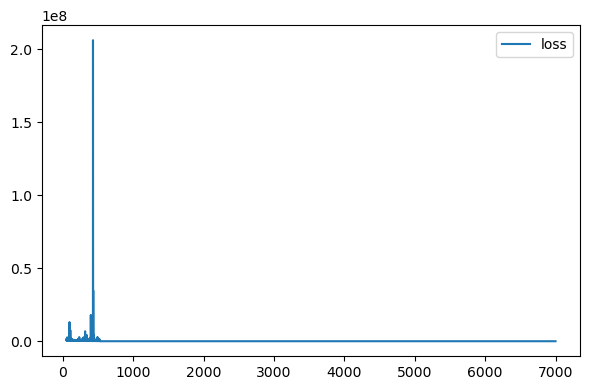

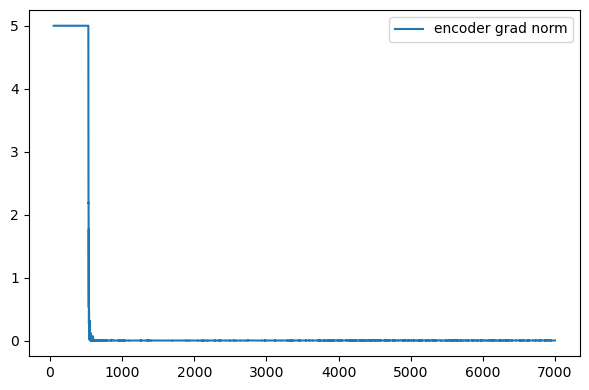

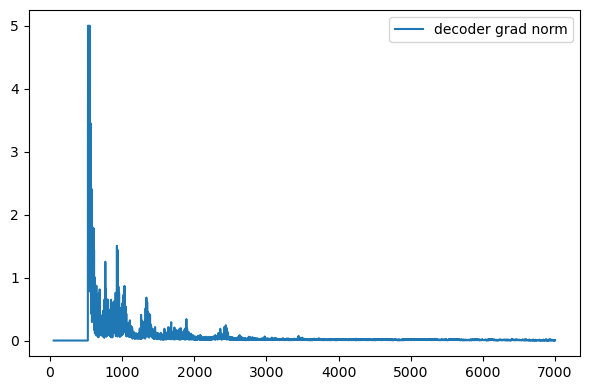

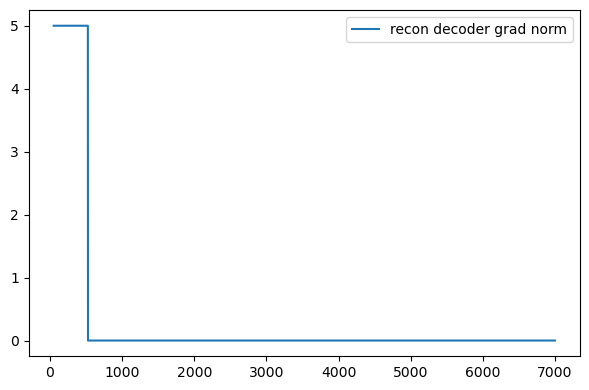

In [19]:
losses = pd.read_csv(tmp_res_dir / "train_losses.csv")

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.loss[50:], label="loss")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.encoder_grad_norm[50:], label="encoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[50:], losses.decoder_grad_norm[50:], label="decoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(
    losses.step[50:],
    losses.recon_decoder_grad_norm[50:],
    label="recon decoder grad norm",
)
plt.legend()
plt.show()

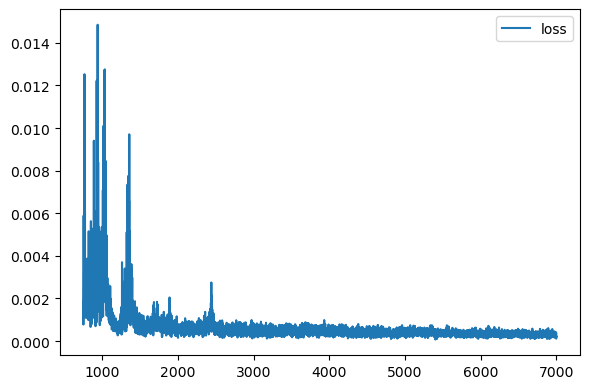

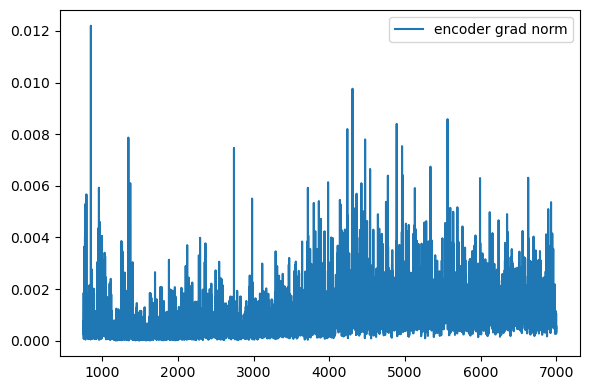

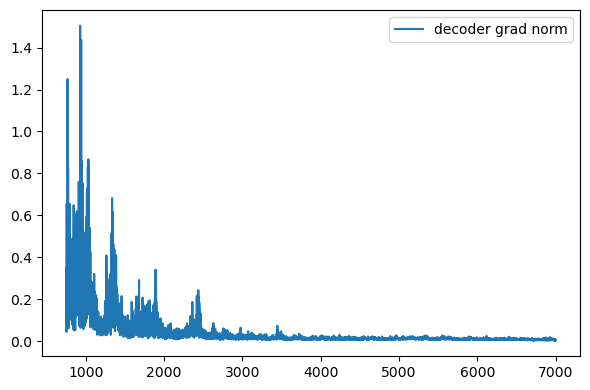

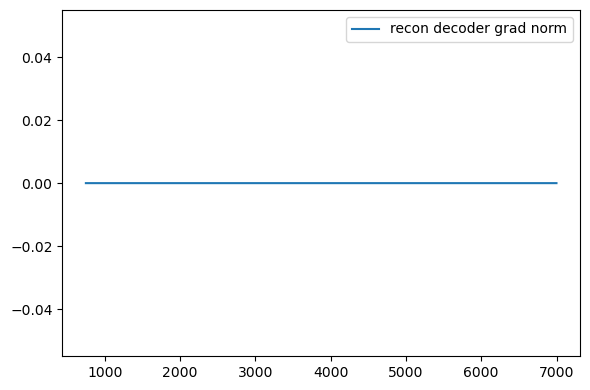

In [20]:
plt.figure(dpi=100)
plt.plot(losses.step[750:], losses.loss[750:], label="loss")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[750:], losses.encoder_grad_norm[750:], label="encoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(losses.step[750:], losses.decoder_grad_norm[750:], label="decoder grad norm")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot(
    losses.step[750:],
    losses.recon_decoder_grad_norm[750:],
    label="recon decoder grad norm",
)
plt.legend()
plt.show()

## Testing & Visualization